In [1]:
# Import libraries
import numpy as np
import pandas as pd
from obspy import read
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import os
from scipy import signal
from matplotlib import cm
import hashlib

In [17]:
def max_subarray_sum_with_index(arr, window_width):
    # Create sliding windows
    windows = np.lib.stride_tricks.sliding_window_view(arr, window_width)
    
    # Compute the sum of elements in each window
    window_sums = windows.sum(axis=1)
    
    # Find the index of the maximum sum
    max_index = np.argmax(window_sums)
    
    # Return the starting index of the maximum sum window
    return max_index

In [36]:
def create_catalog(base_dir: str, data_dir: str, files: list[str], catalog_name: str, planet: str):
    csv_path = f"./catalogs/{planet}/{catalog_name}.csv" # default to mars
    if planet == "lunar":
        csv_path = f"./catalogs/{planet}/apollo12_catalog_{catalog_name}_final.csv"
    with open(csv_path, "w") as catalog_file:
        catalog_file.write("filename,time_rel(sec)\n")
        for filename in files:
            # arrival_time = datetime.strptime(row['time_abs(%Y-%m-%dT%H:%M:%S.%f)'],'%Y-%m-%dT%H:%M:%S.%f')
            mseed_file = f'{base_dir}/{data_dir}/{filename}.mseed'
            if planet == 'lunar':
                mseed_file = f'{base_dir}/{data_dir}/{catalog_name}/{filename}.mseed'

            st = read(mseed_file)
            
            tr = st.traces[0].copy()

            # Set the minimum frequency
            minfreq = 0.5
            maxfreq = 1.0

            # Going to create a separate trace for the filter data
            st_filt = st.copy()
            st_filt.filter('bandpass',freqmin=minfreq,freqmax=maxfreq)
            tr_filt = st_filt.traces[0].copy()
            tr_times_filt = tr_filt.times()
            tr_data_filt = tr_filt.data

            # Start time of trace (another way to get the relative arrival time using datetime)
            f, t, sxx = signal.spectrogram(tr_data_filt, tr_filt.stats.sampling_rate)

            sums = np.sum(sxx, axis=0)
            window_width = 70 # default for mars - best window size
            if planet == "lunar":
                window_width = 40 # best window size for moon
            
            max_index = max_subarray_sum_with_index(sums, window_width)
            predicted_time = max_index * tr_times_filt[-1] / len(sums)
            
            catalog_file.write(f"{filename},{predicted_time}\n")
            
            # Plot the time series
            
            fig = plt.figure(figsize=(10, 10))
            ax = plt.subplot(2, 1, 1)
            # Plot trace
            ax.plot(tr_times_filt,tr_data_filt)

            # Mark detection
            ax.axvline(x = predicted_time, color='red',label='Detection')
            ax.legend(loc='upper left')

            # Make the plot pretty
            ax.set_title(f"{filename} Prediction")
            ax.set_xlim([min(tr_times_filt),max(tr_times_filt)])
            ax.set_ylabel('Velocity (m/s)')
            ax.set_xlabel('Time (s)')
            save_path = f"./plots/test/{planet}/{filename}_prediction.png"
            if planet == "lunar":
                save_path = f"./plots/test/{planet}/{catalog_name}/{filename}_prediction.png"
                if not os.path.exists(f"./plots/test/{planet}/{catalog_name}"):
                    os.mkdir(f"./plots/test/{planet}/{catalog_name}")
            plt.savefig(save_path)

C:\Users\cgera\AppData\Local\Temp\ipykernel_26088\1273399601.py:43: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(10, 10))


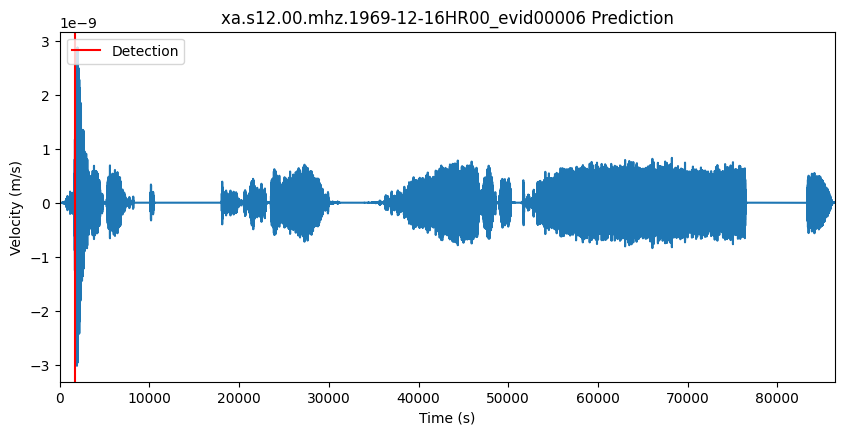

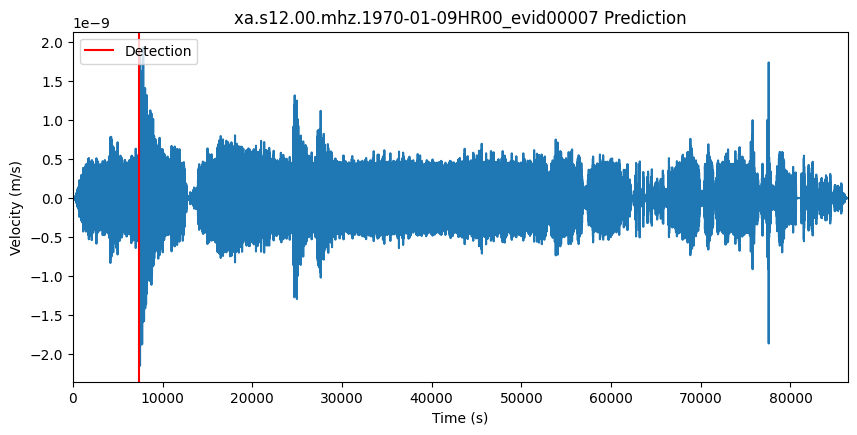

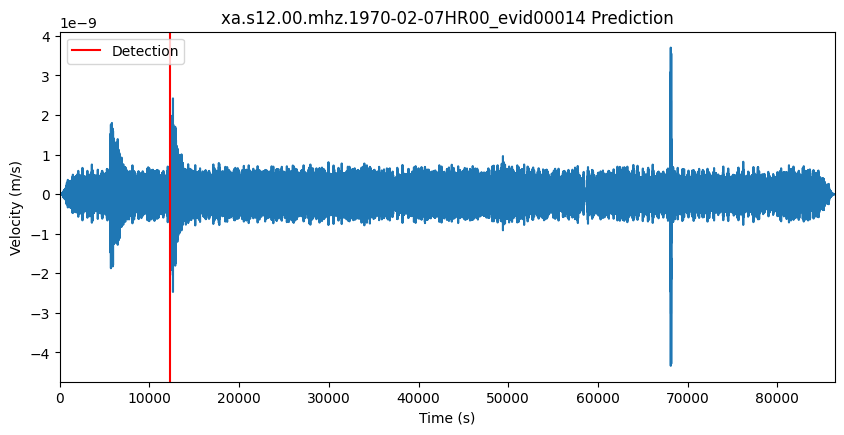

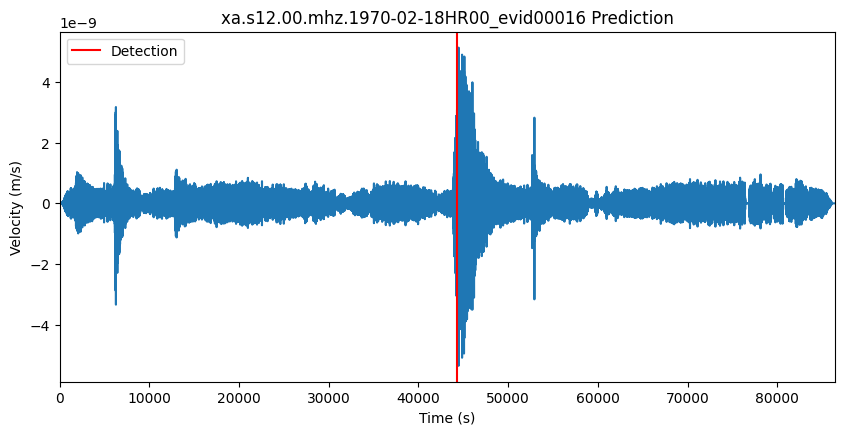

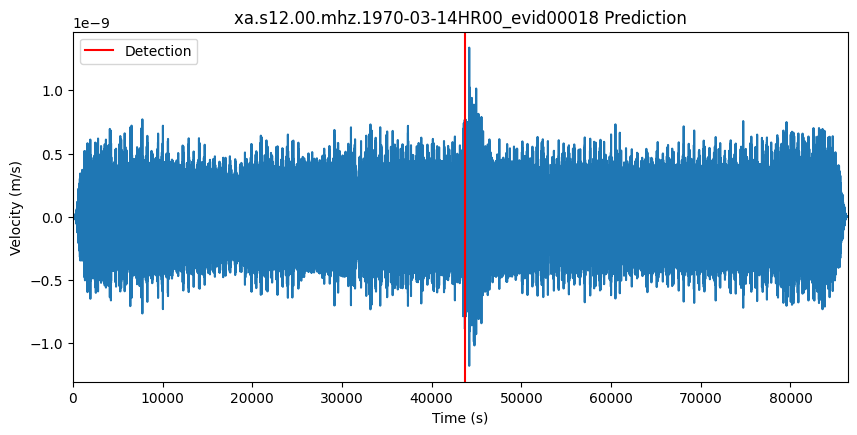

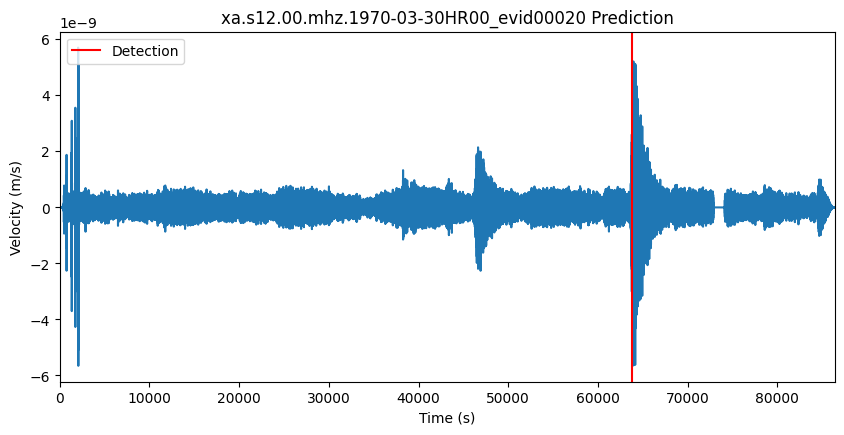

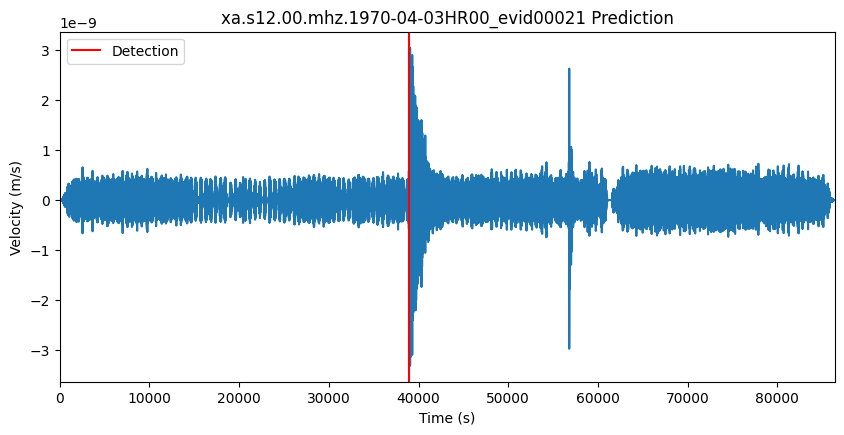

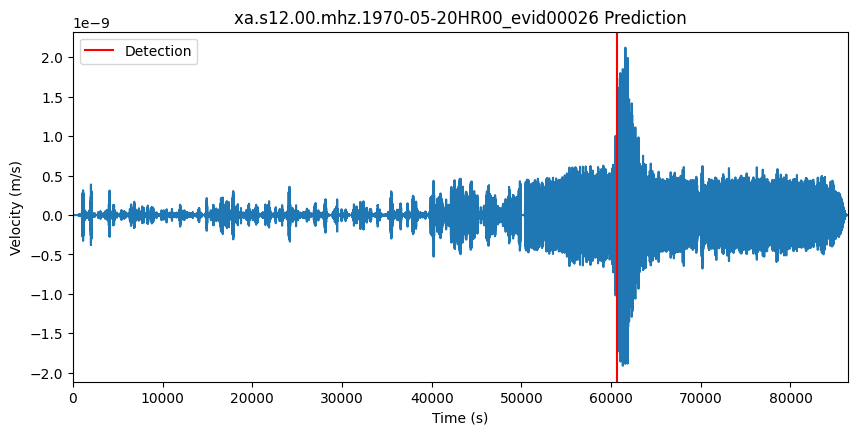

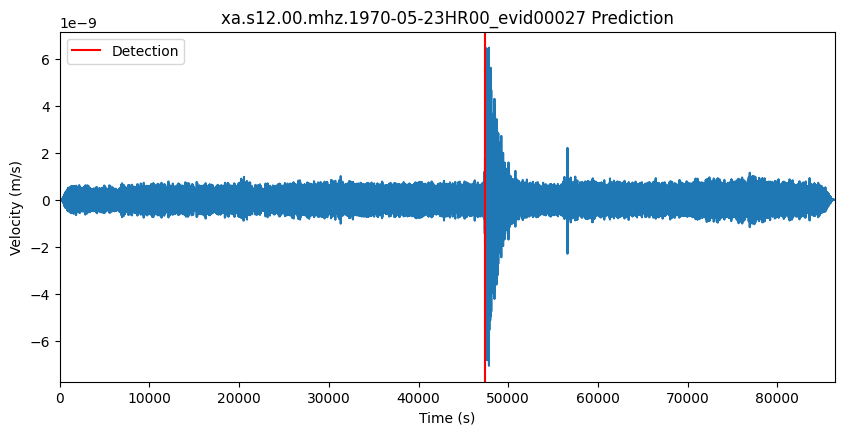

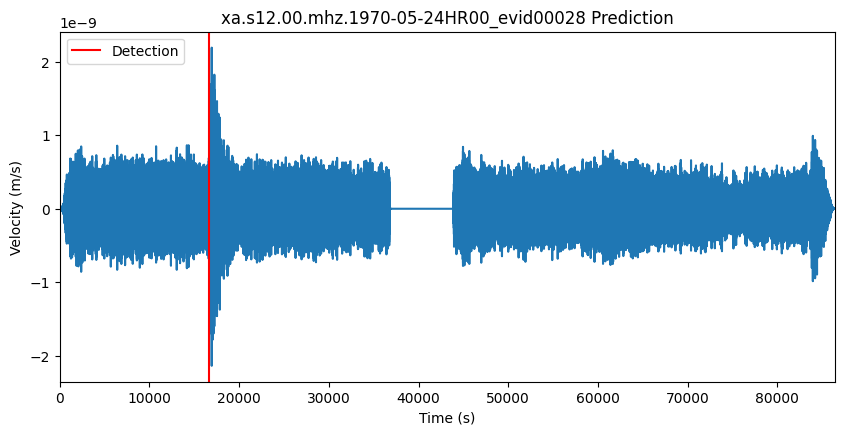

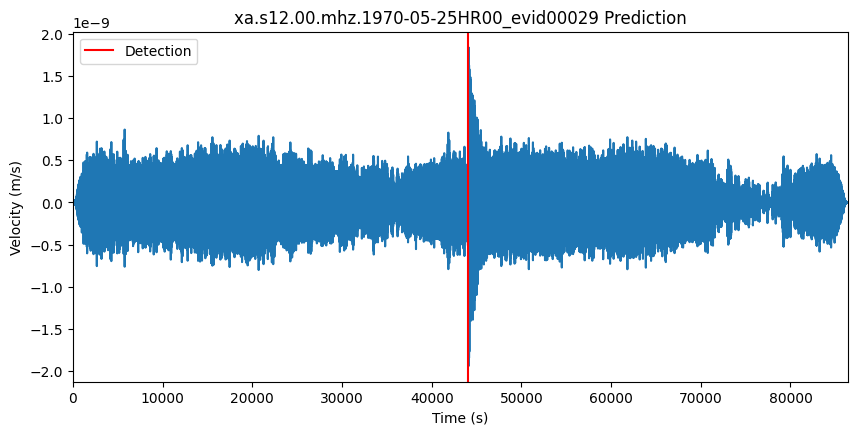

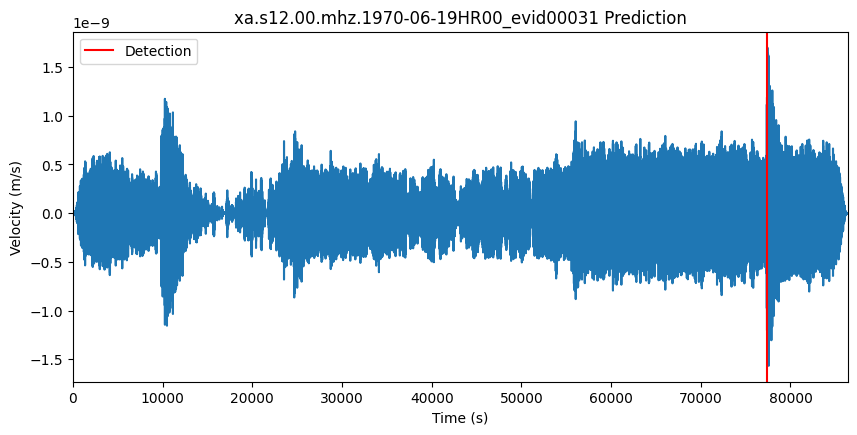

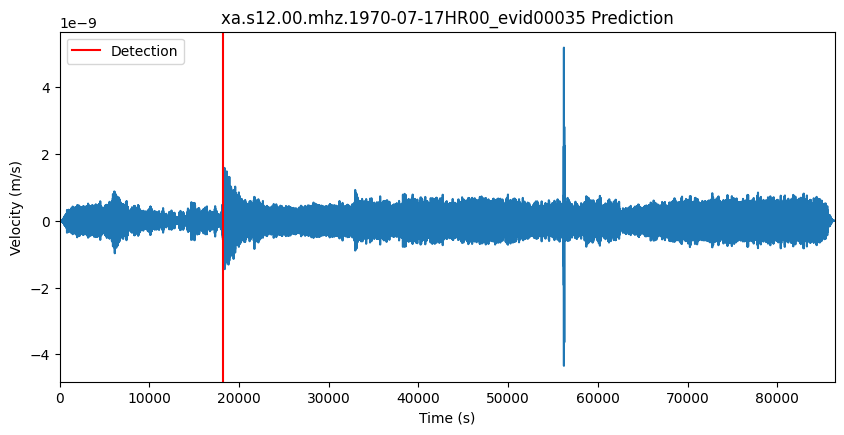

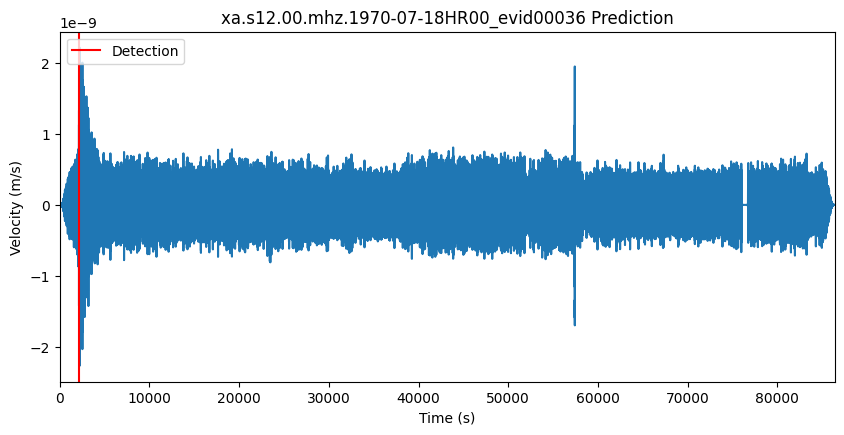

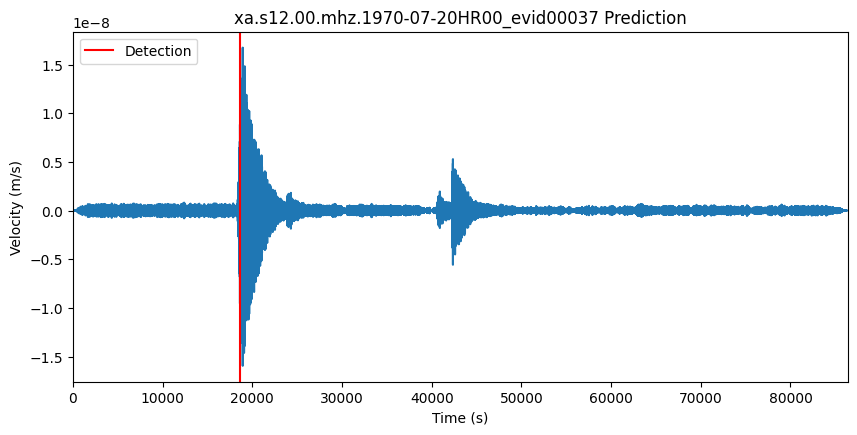

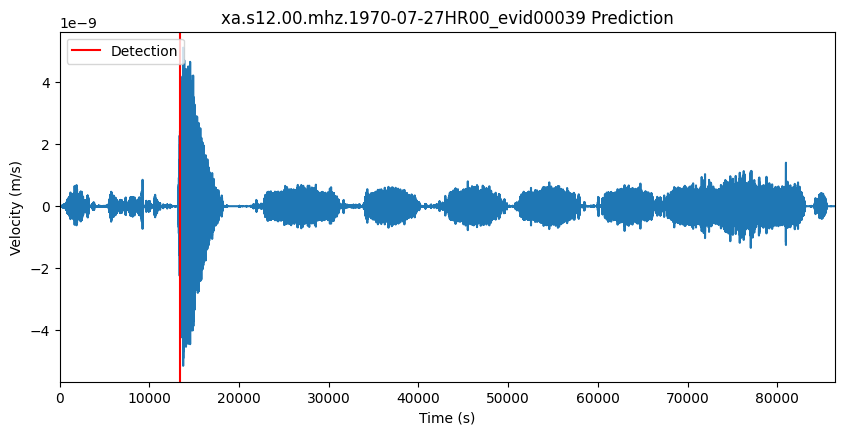

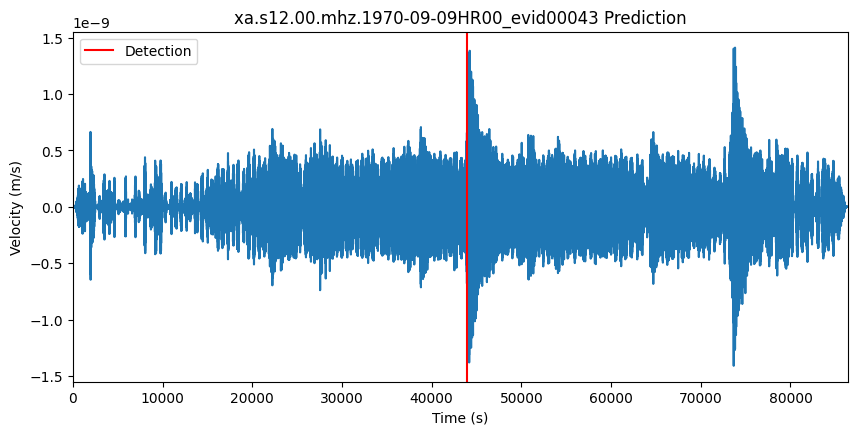

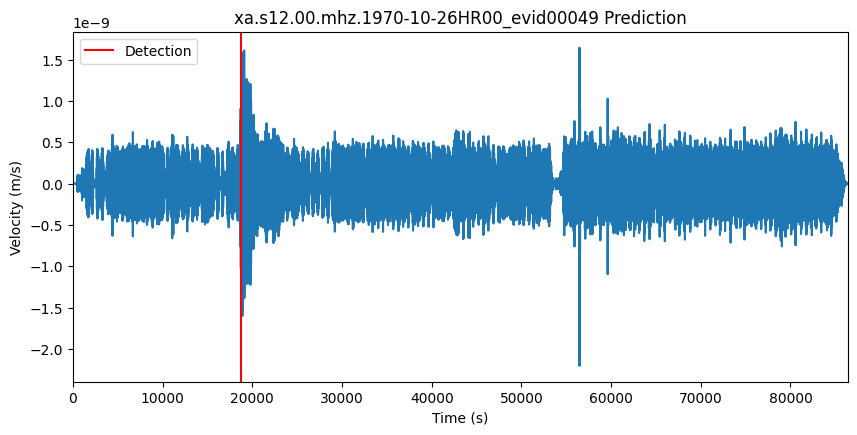

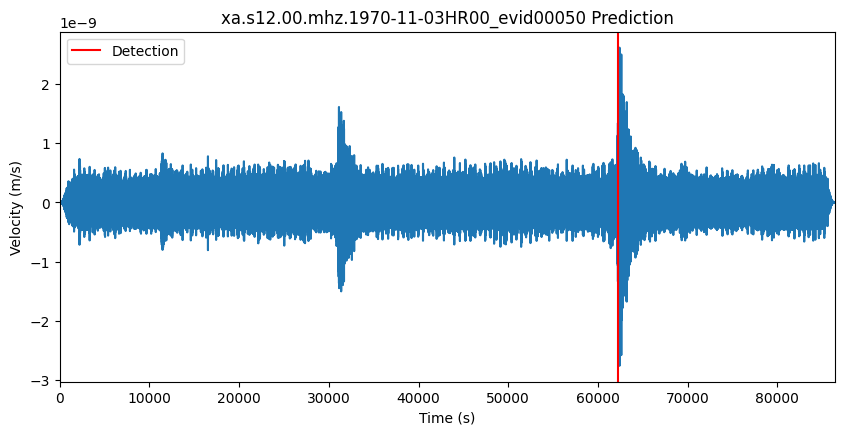

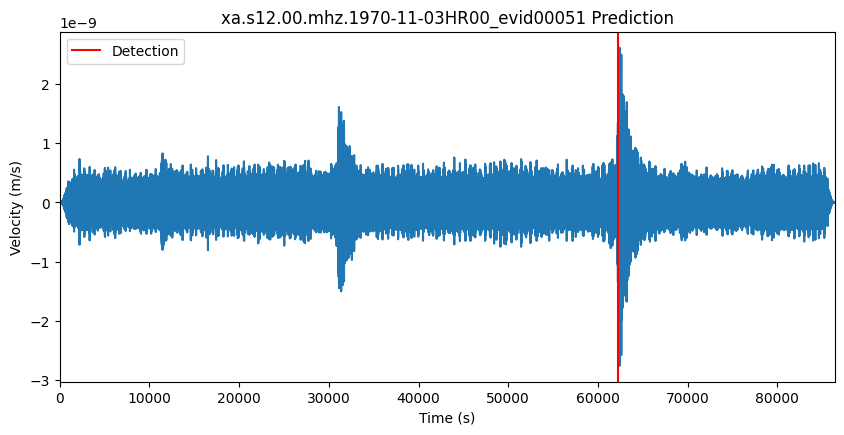

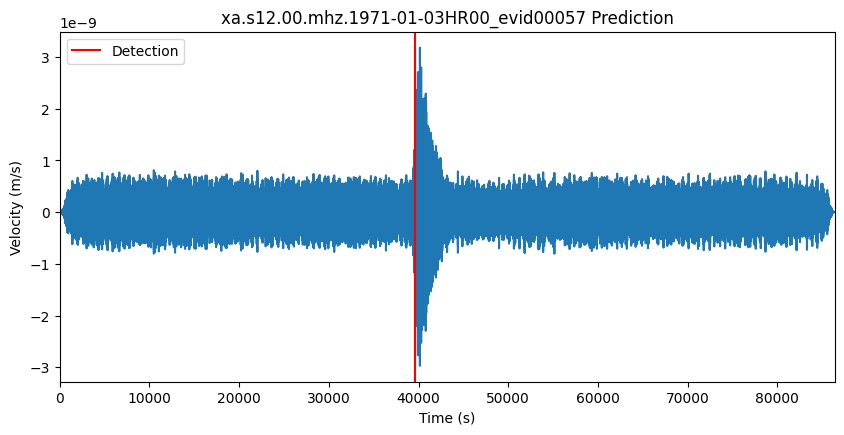

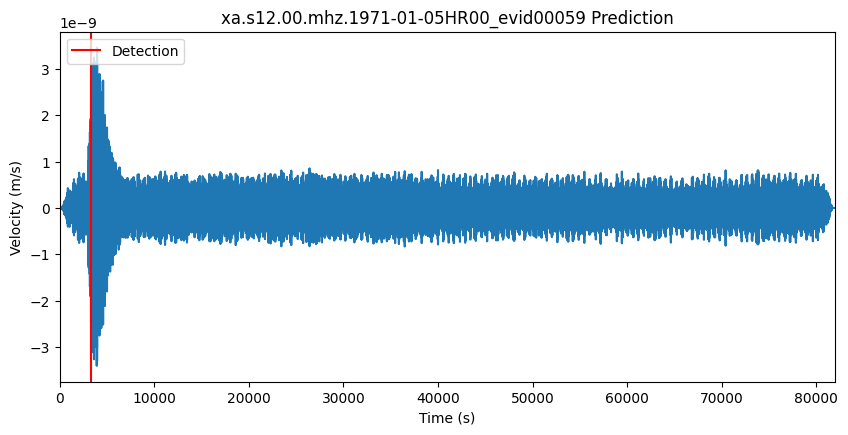

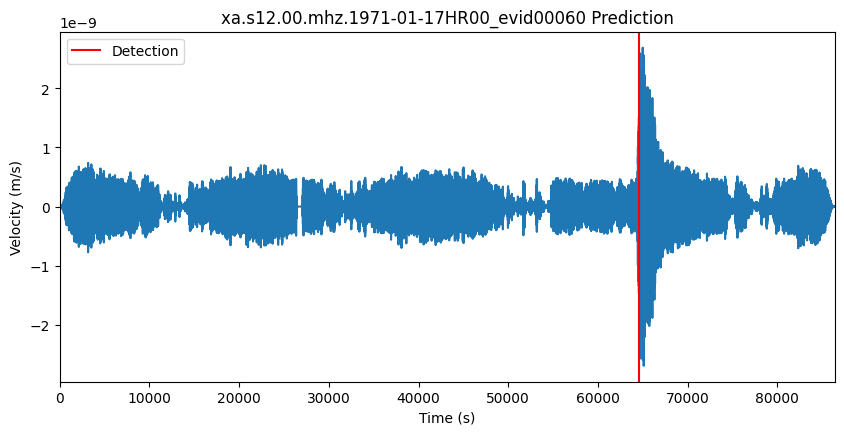

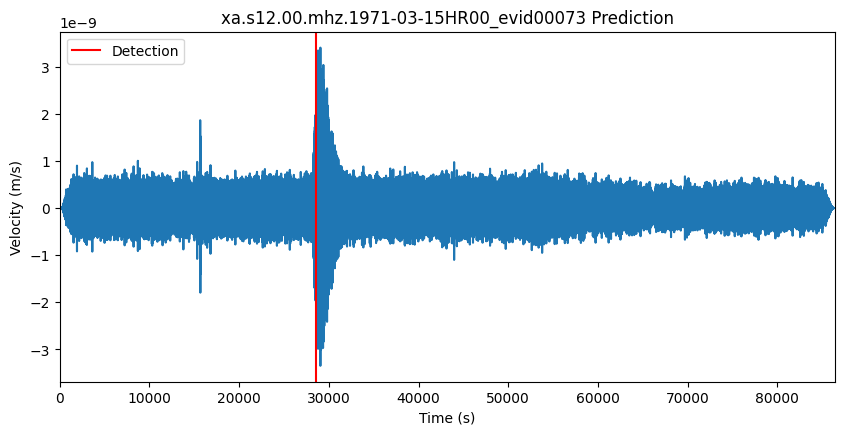

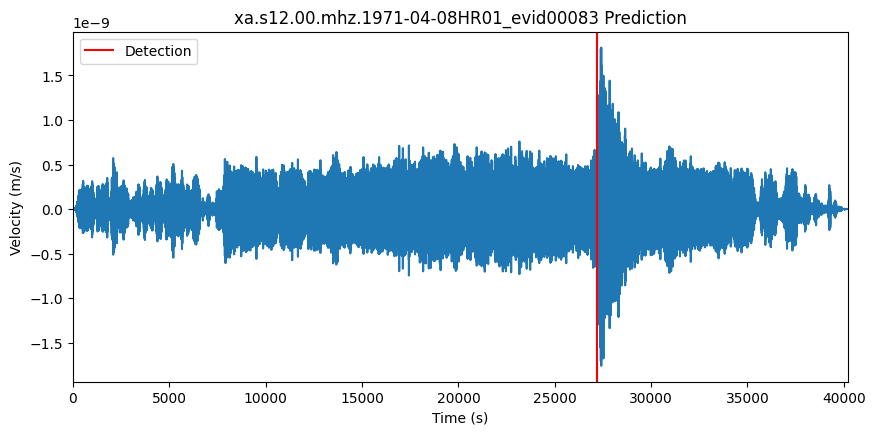

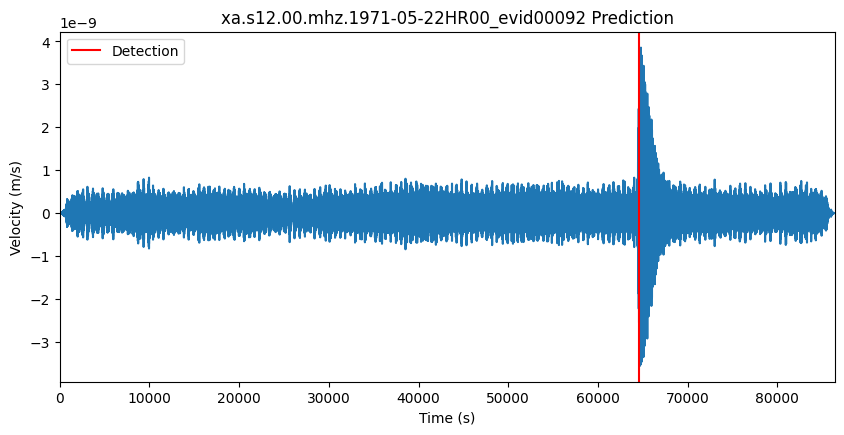

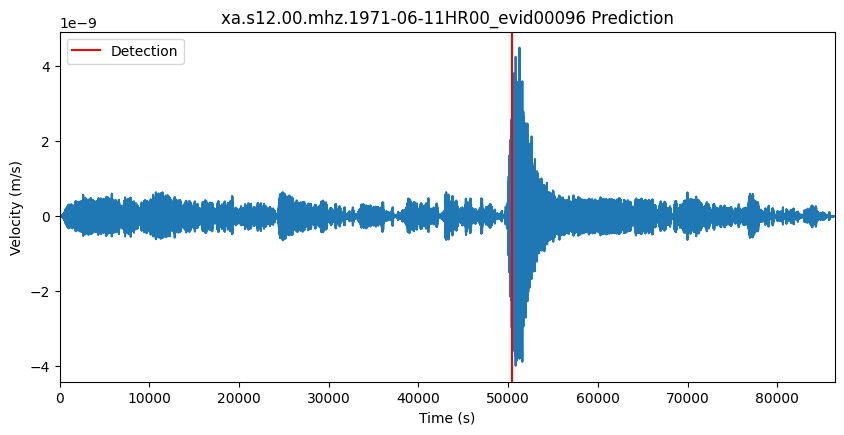

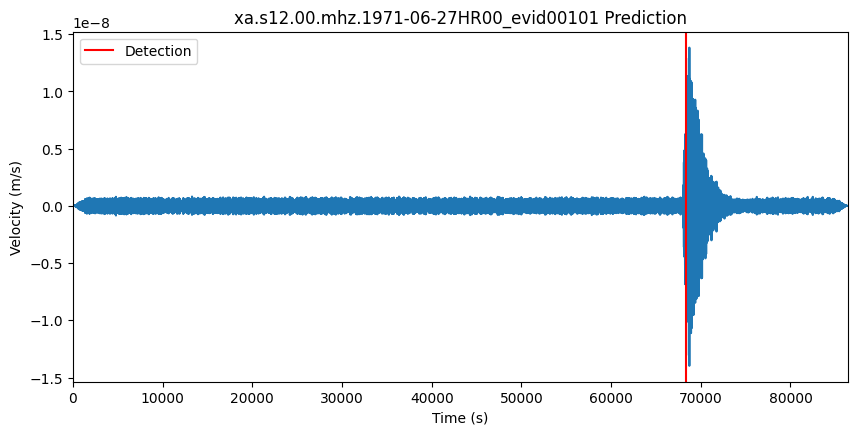

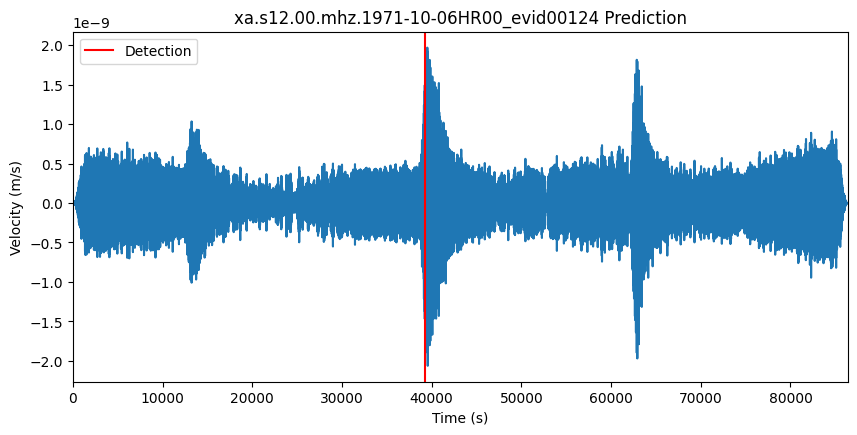

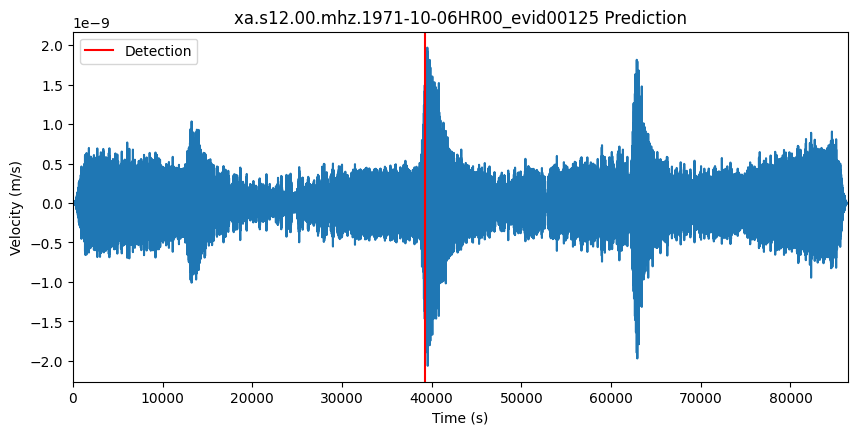

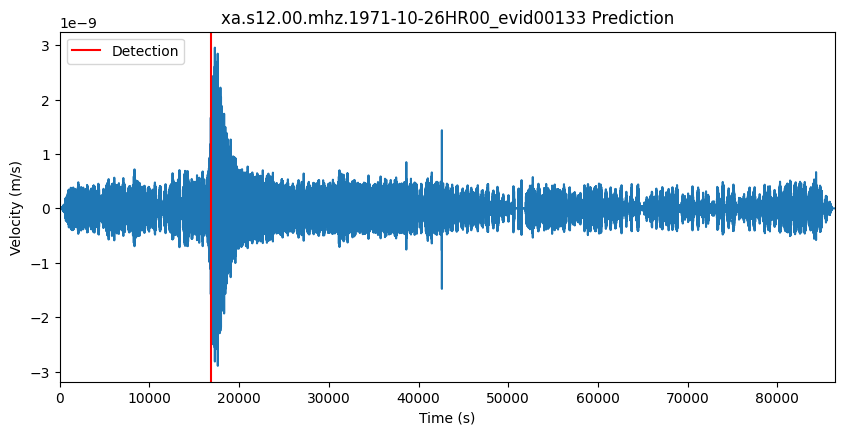

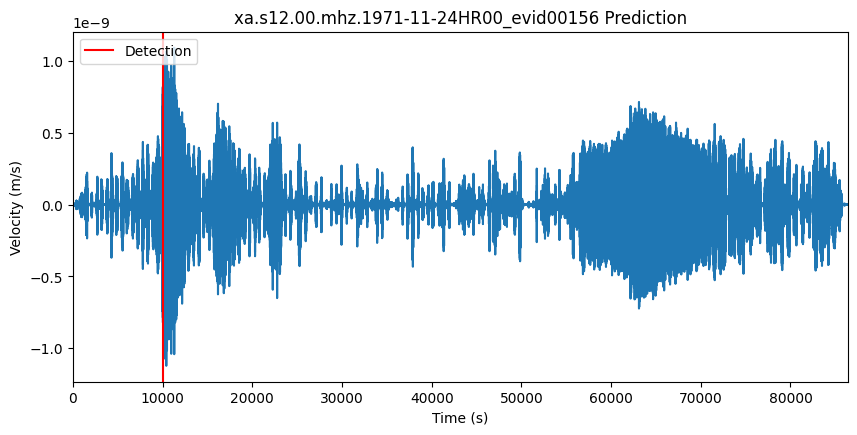

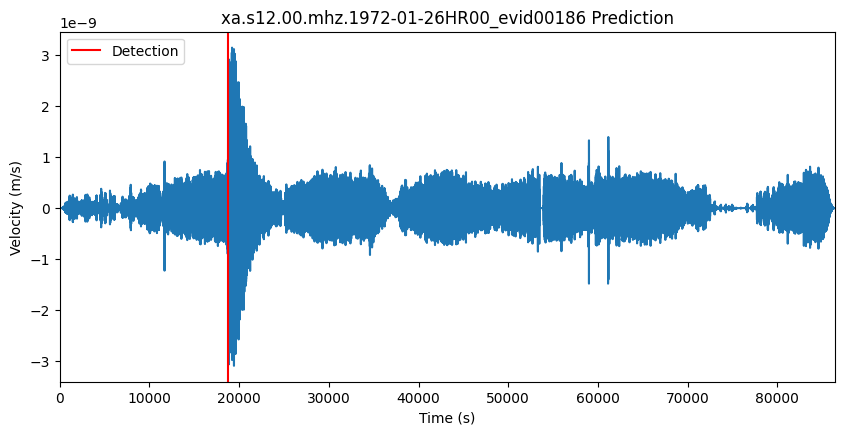

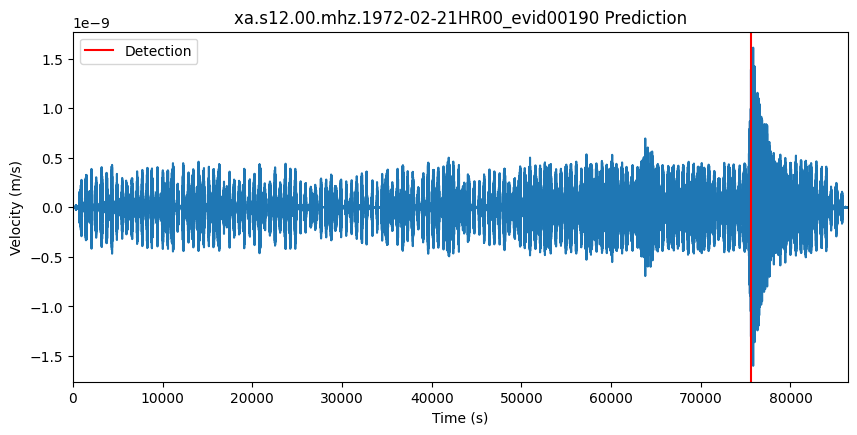

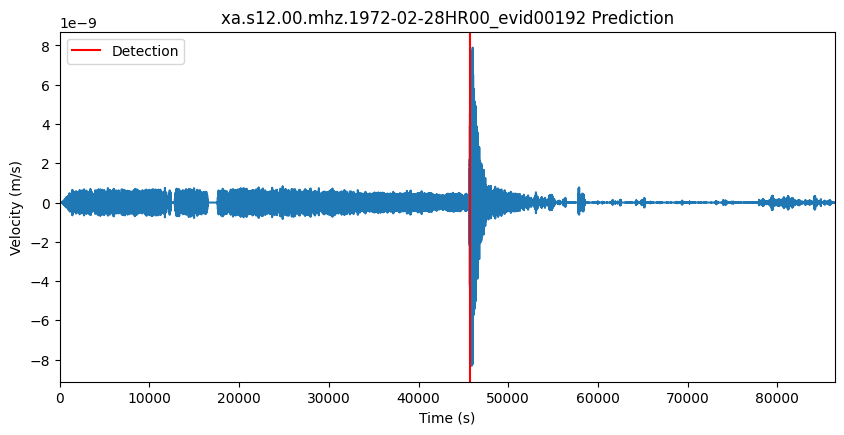

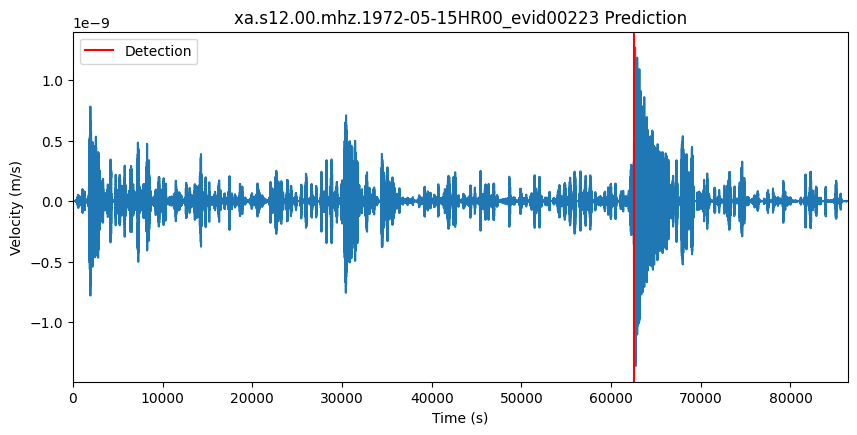

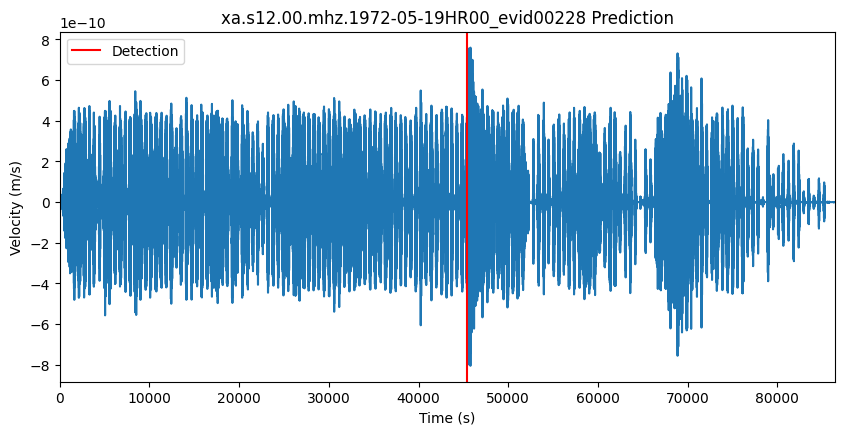

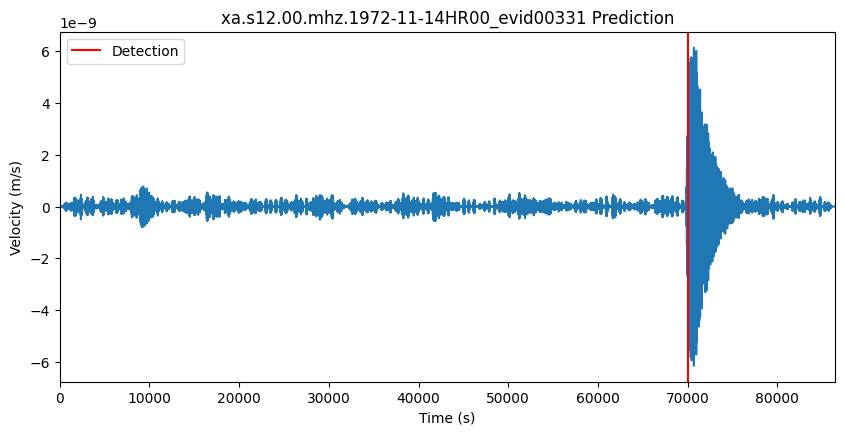

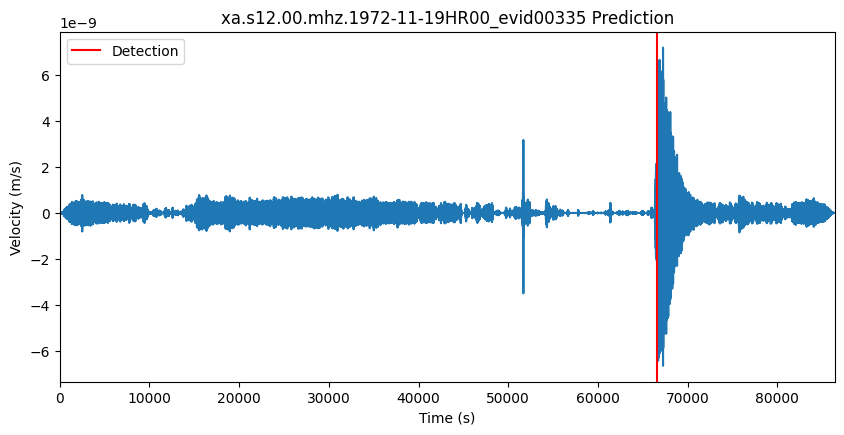

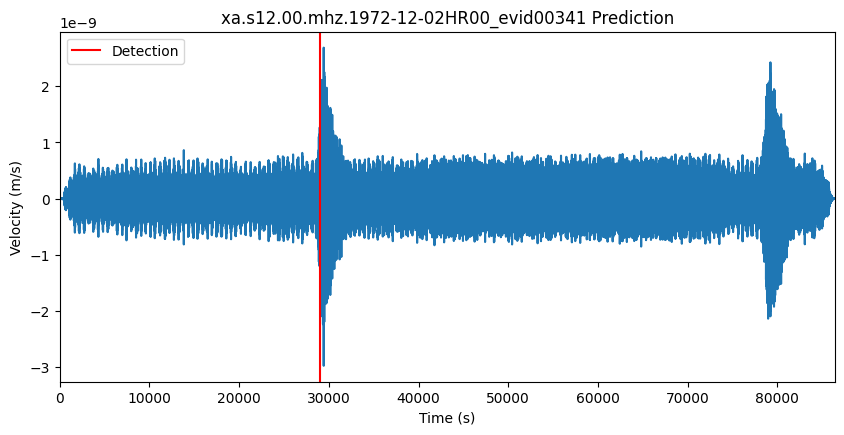

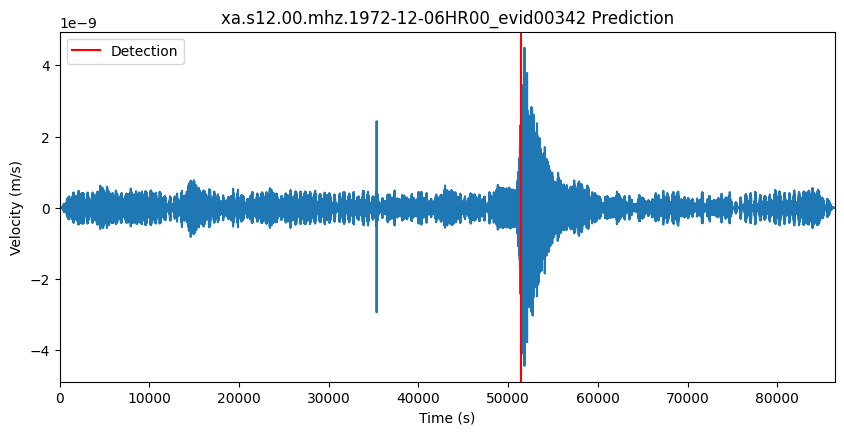

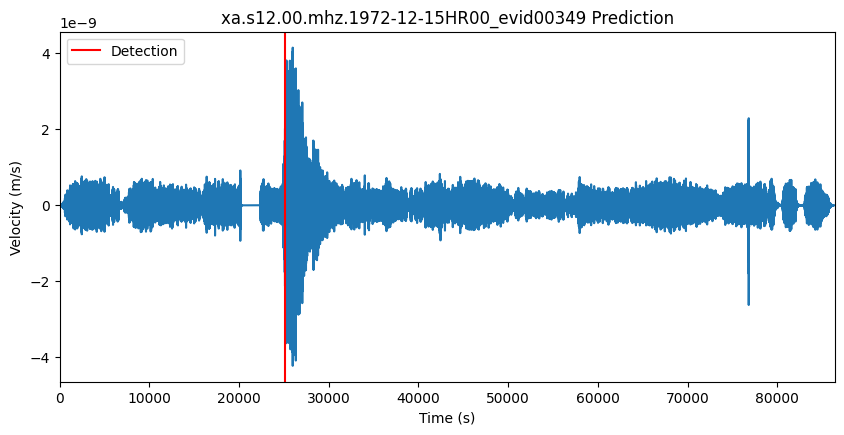

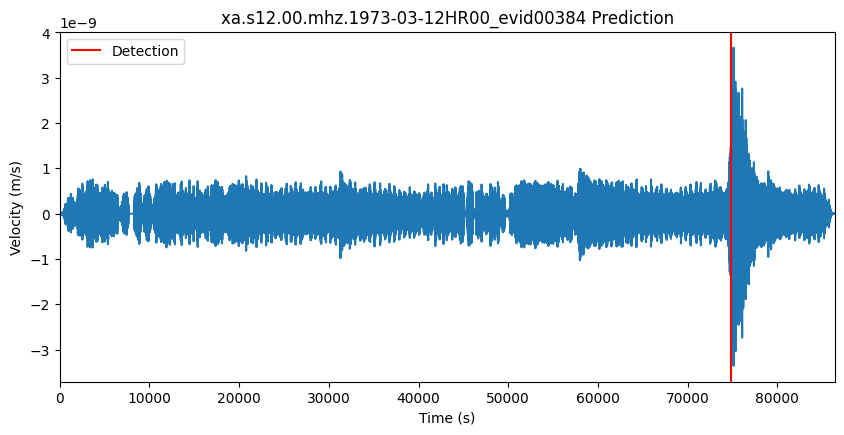

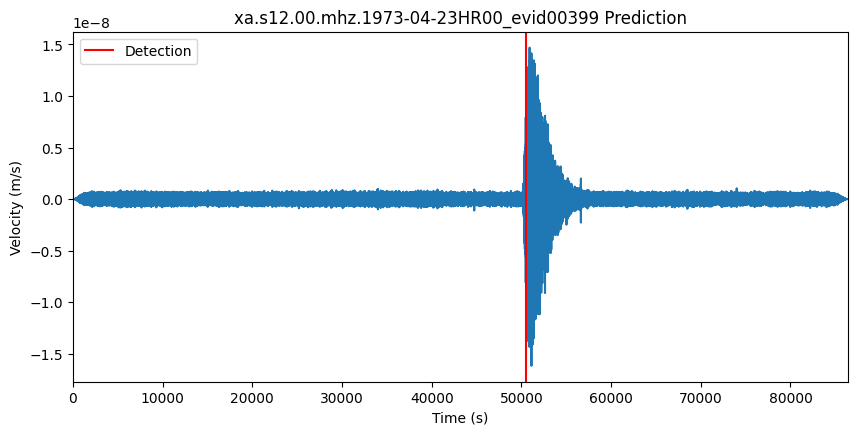

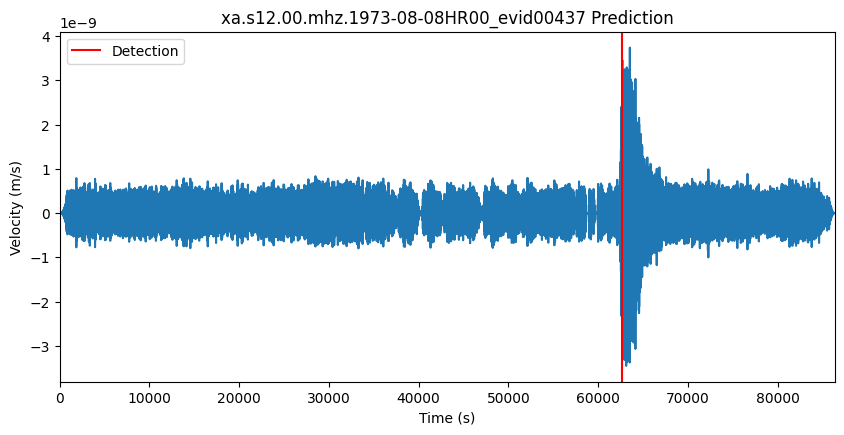

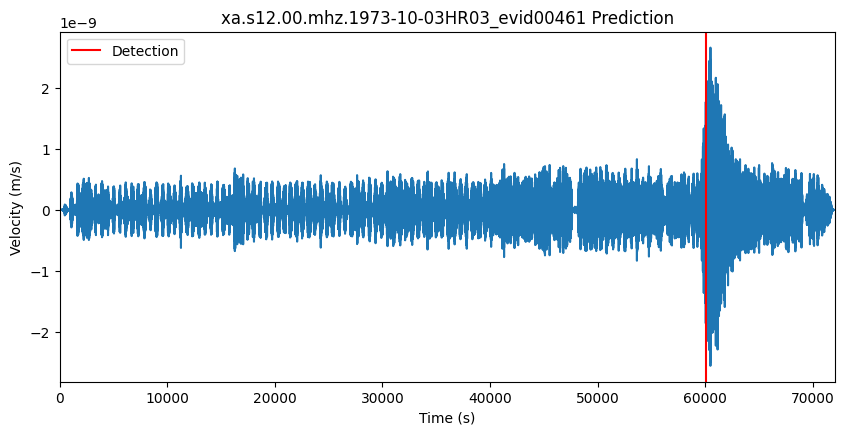

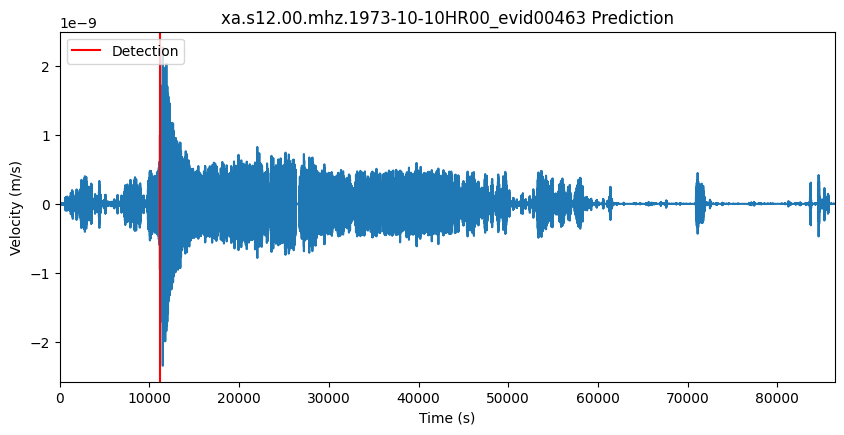

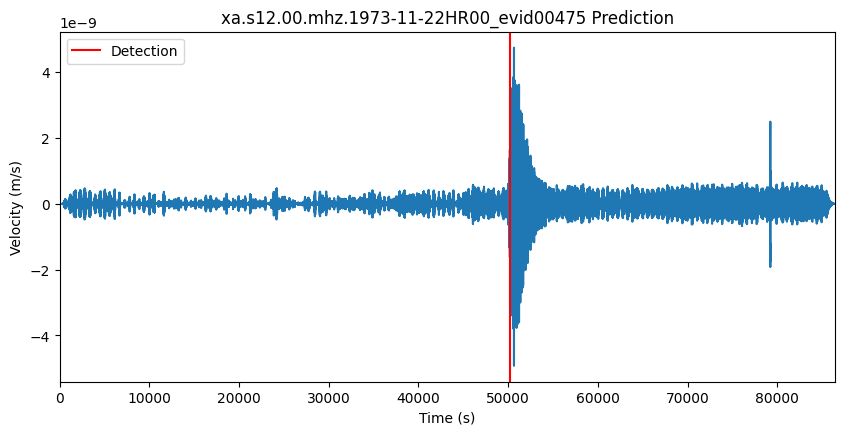

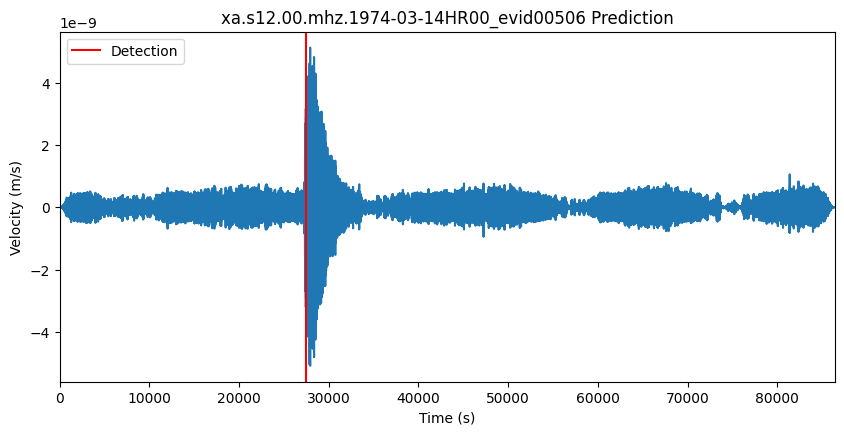

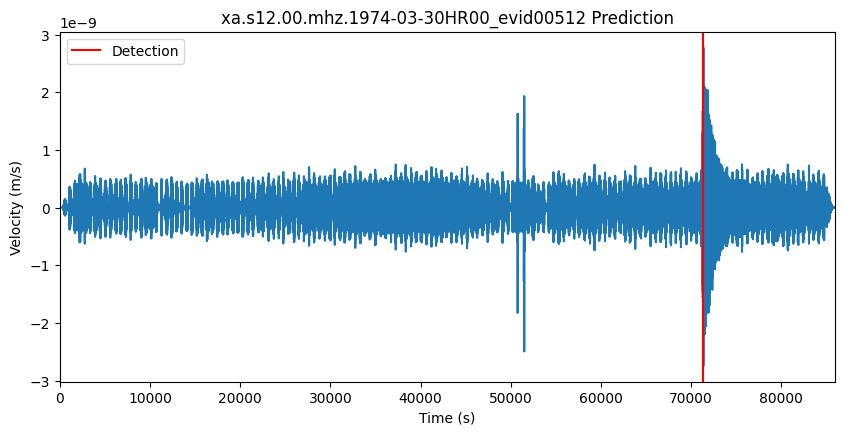

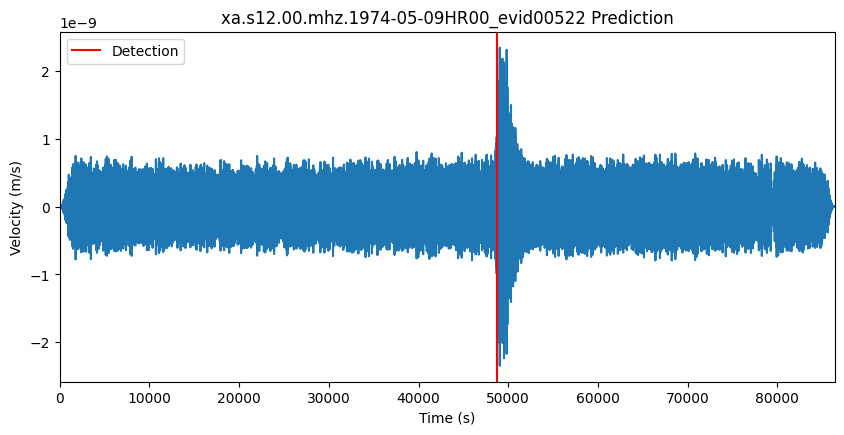

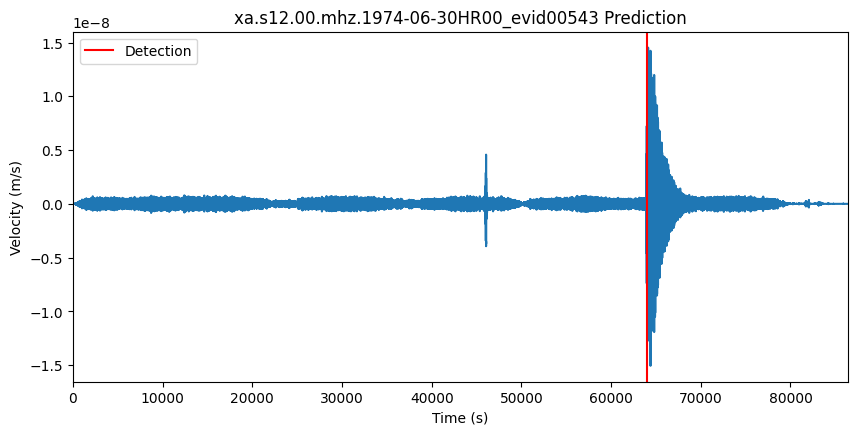

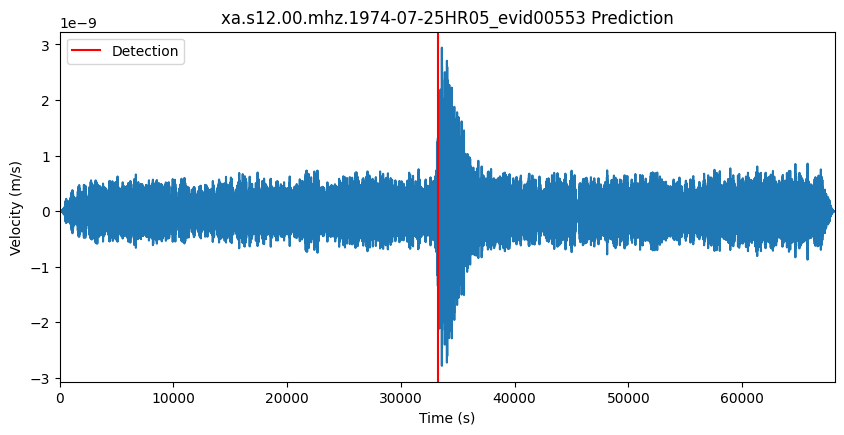

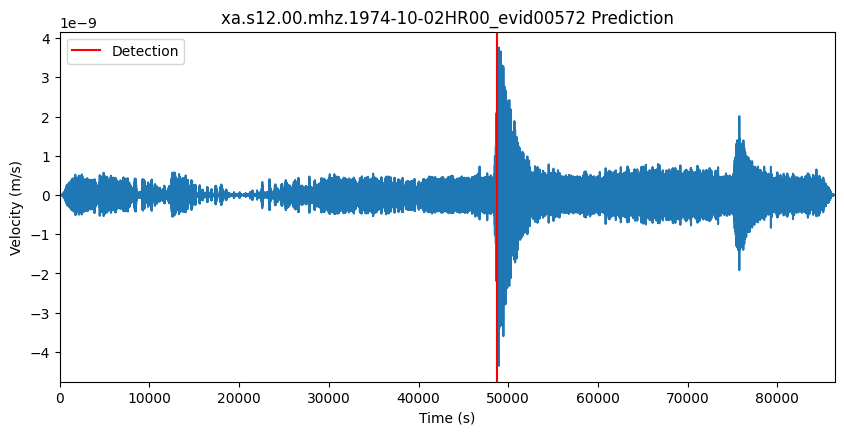

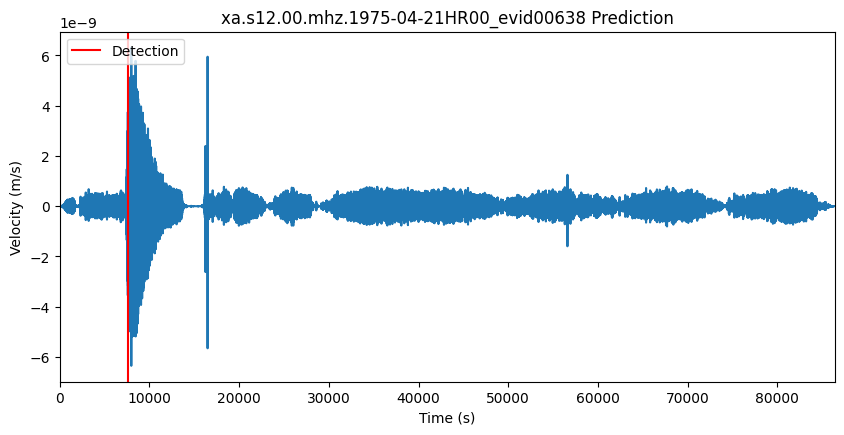

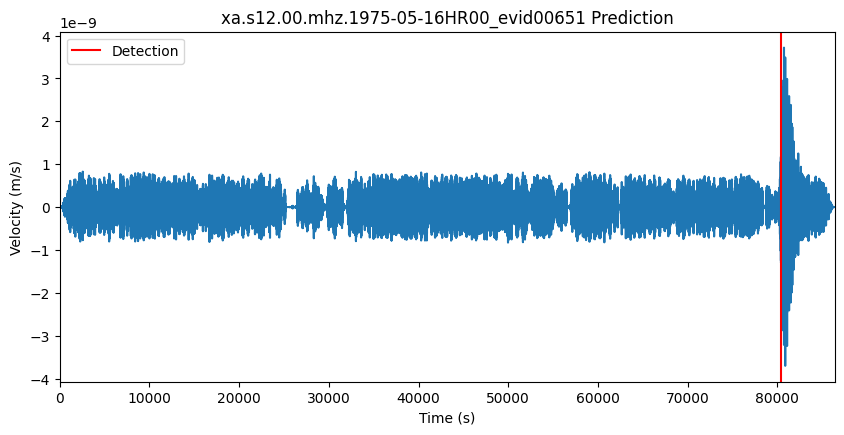

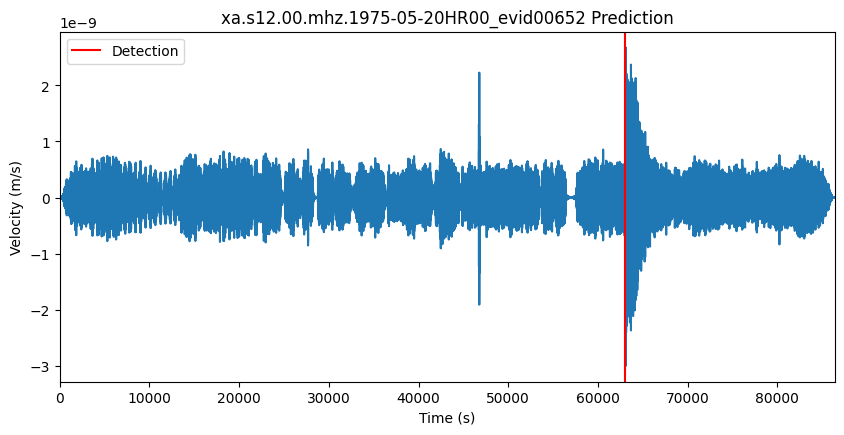

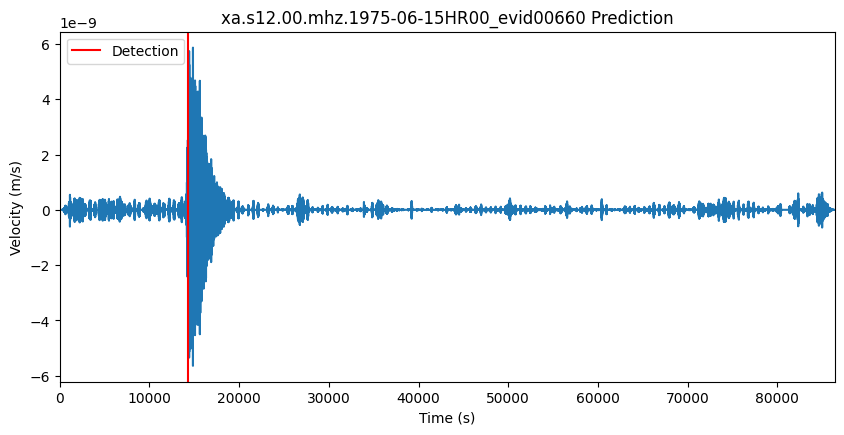

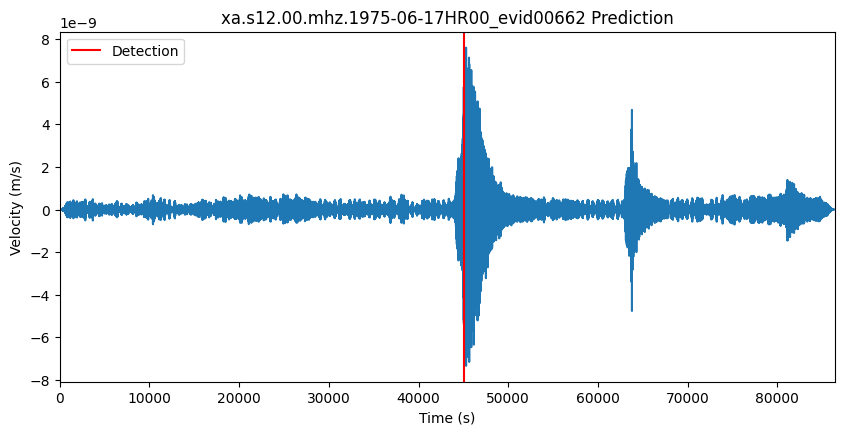

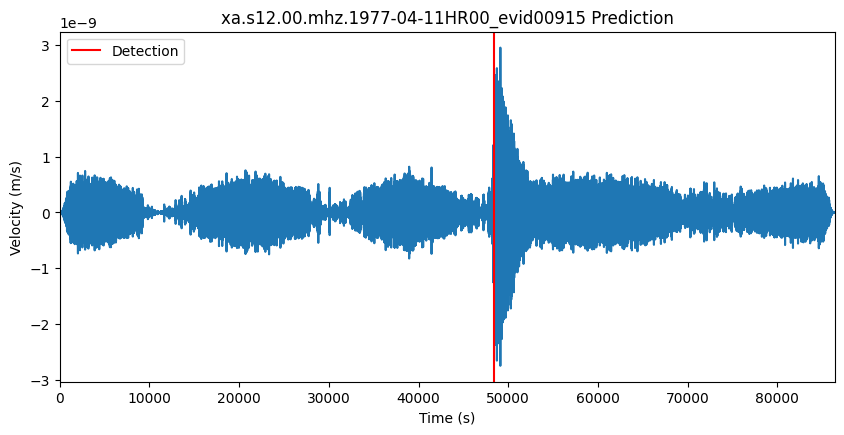

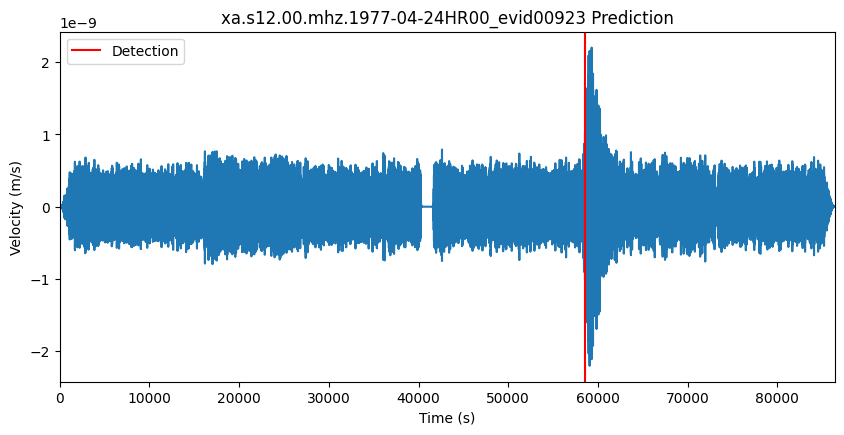

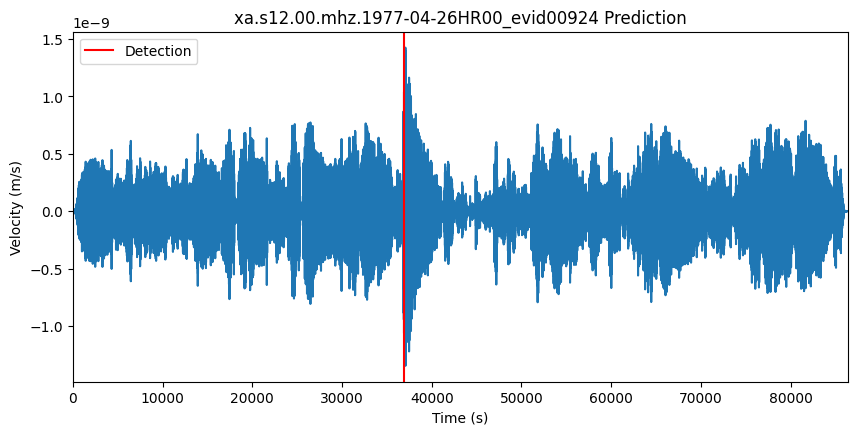

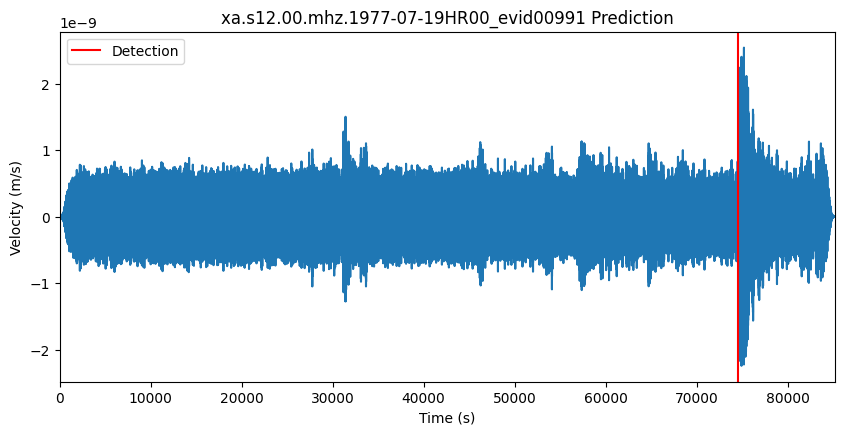

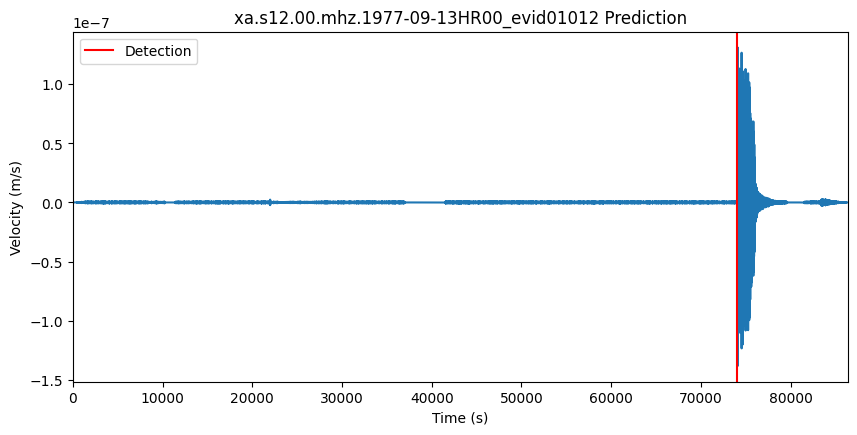

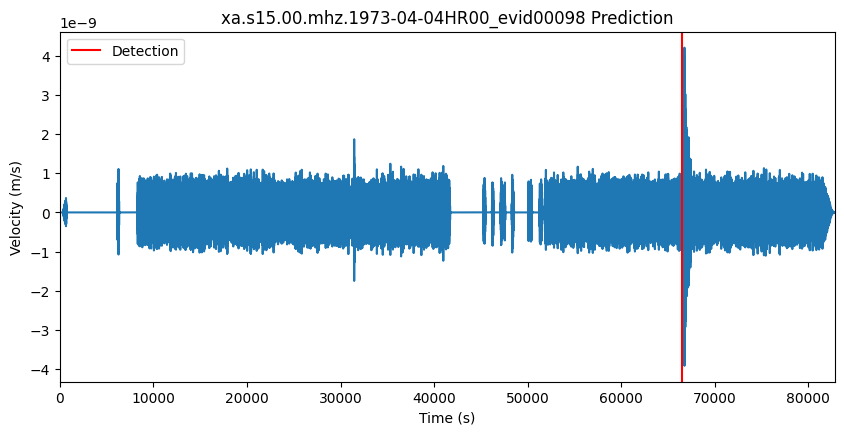

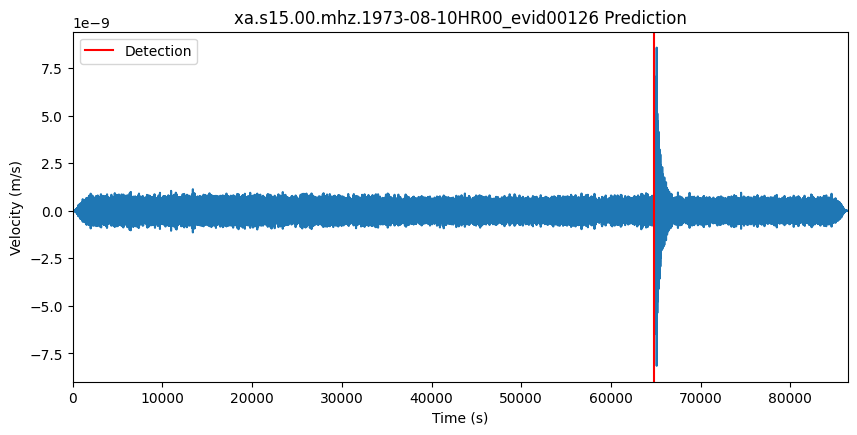

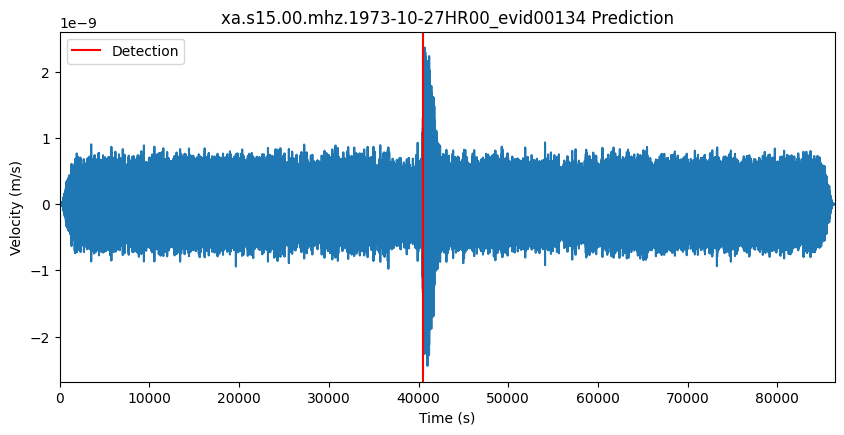

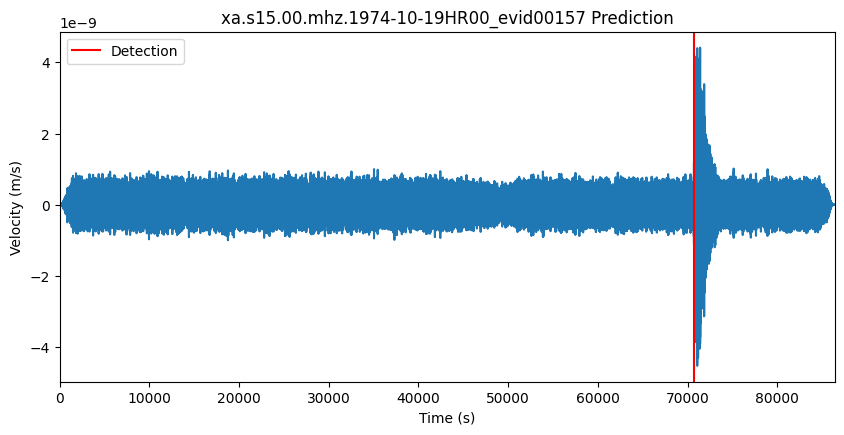

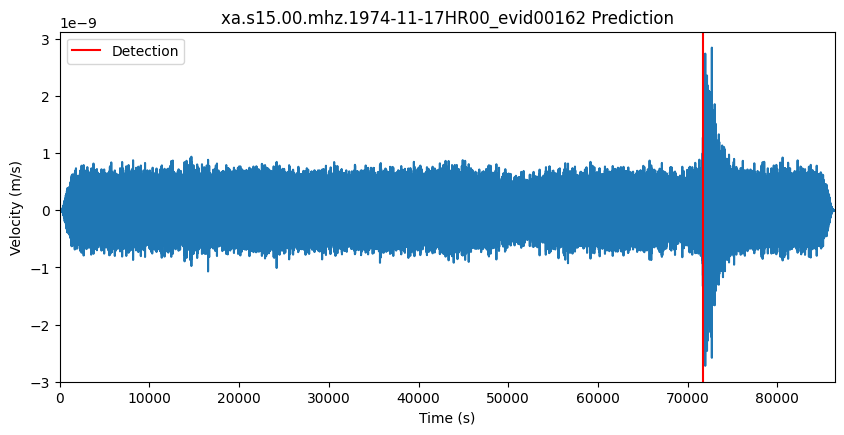

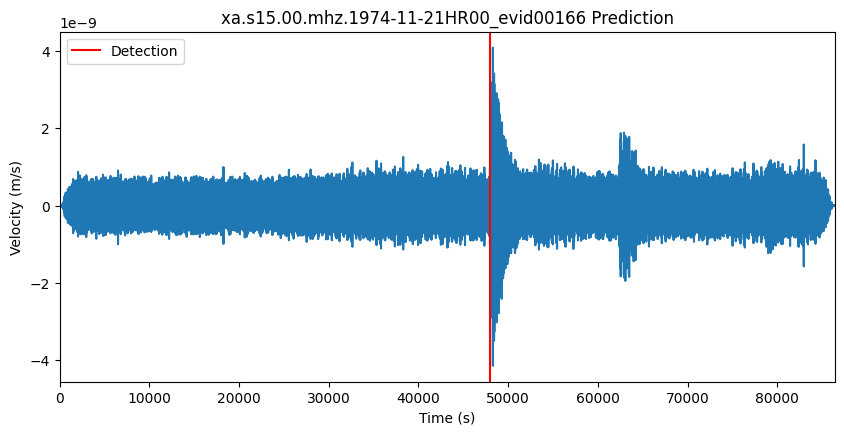

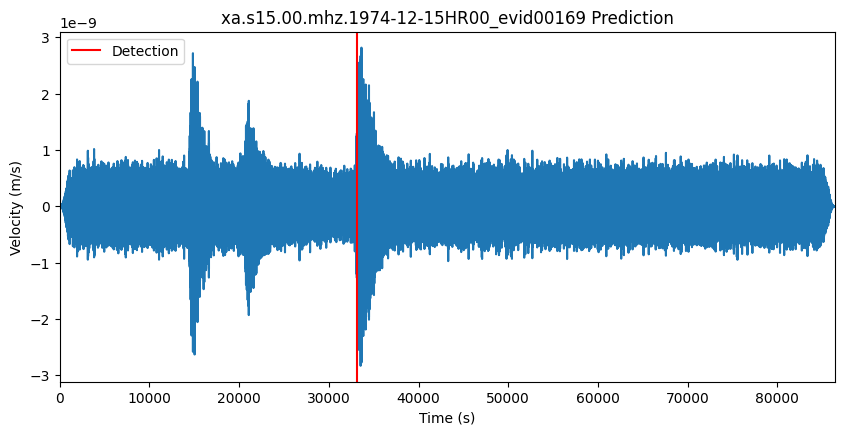

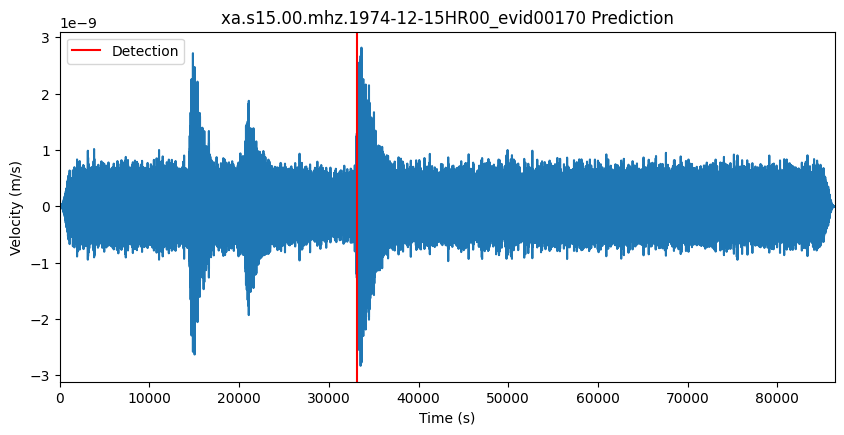

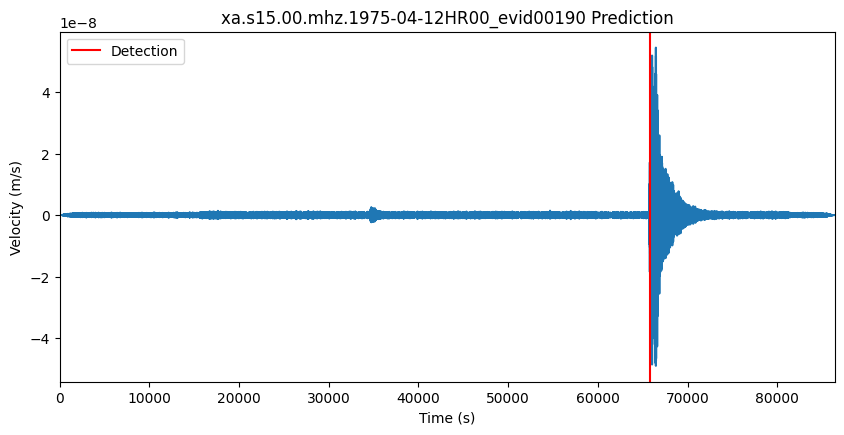

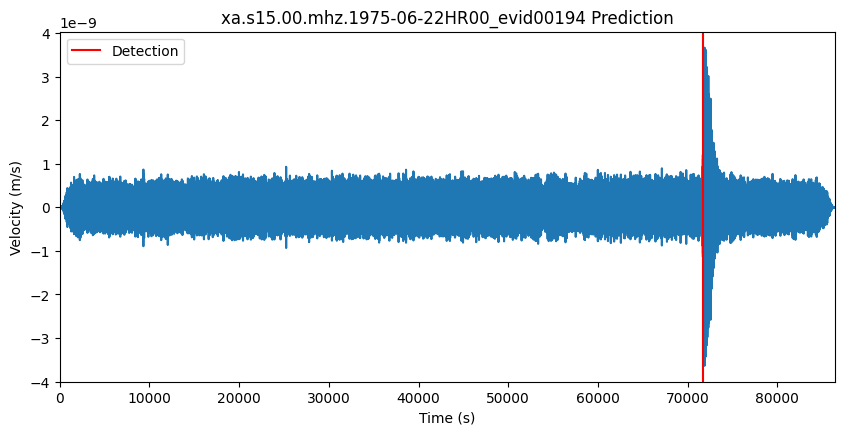

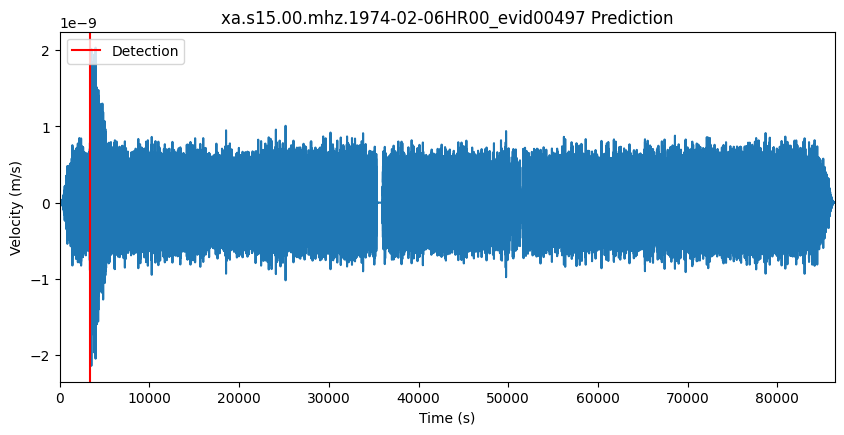

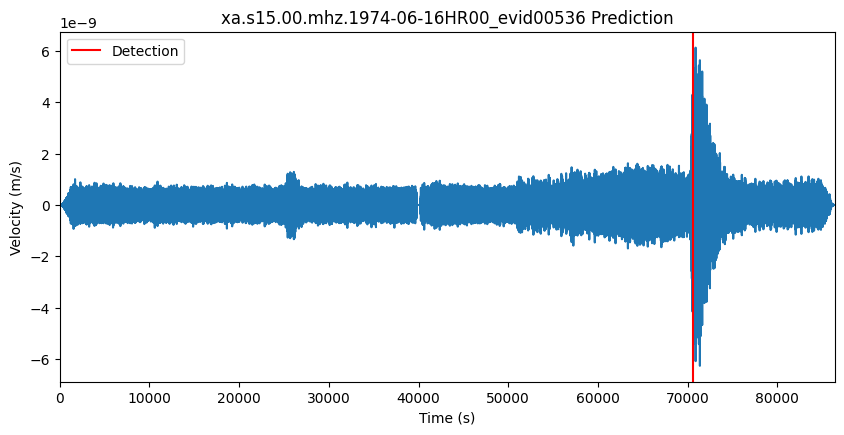

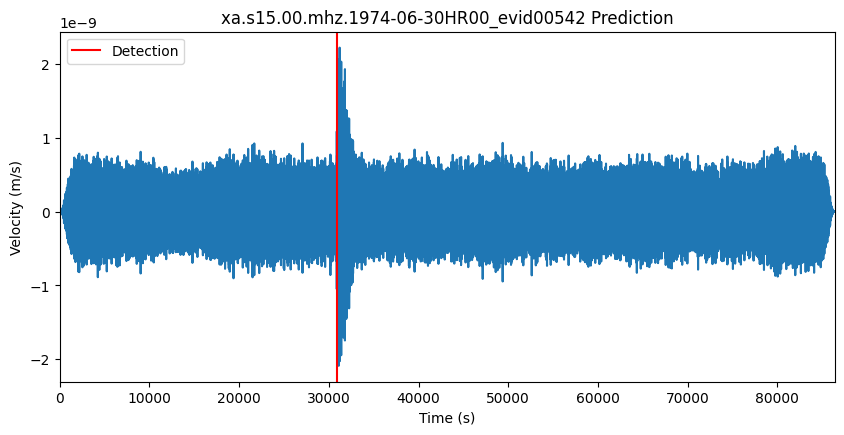

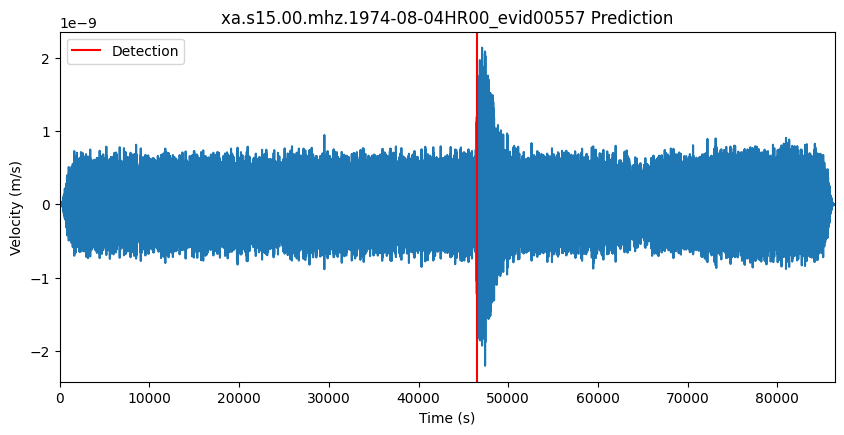

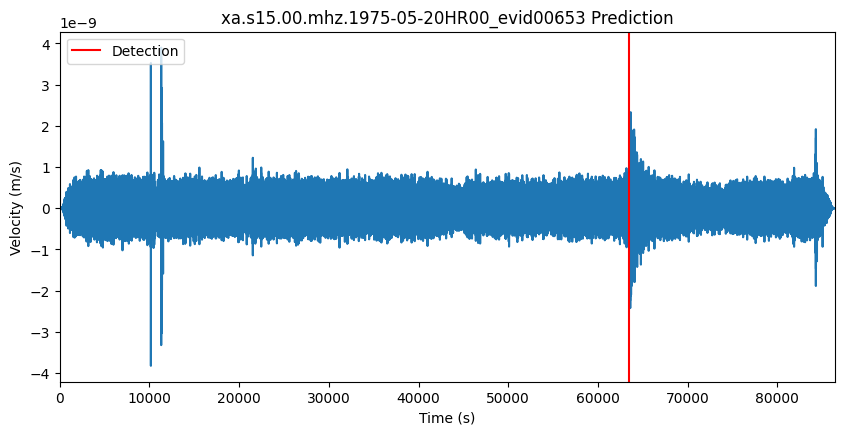

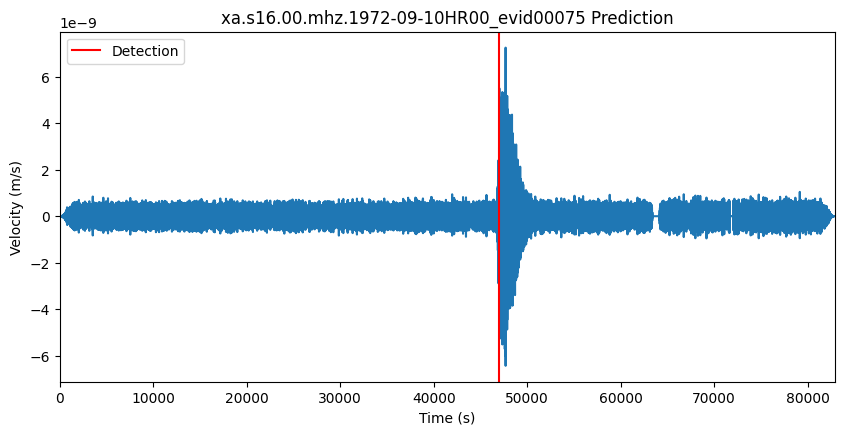

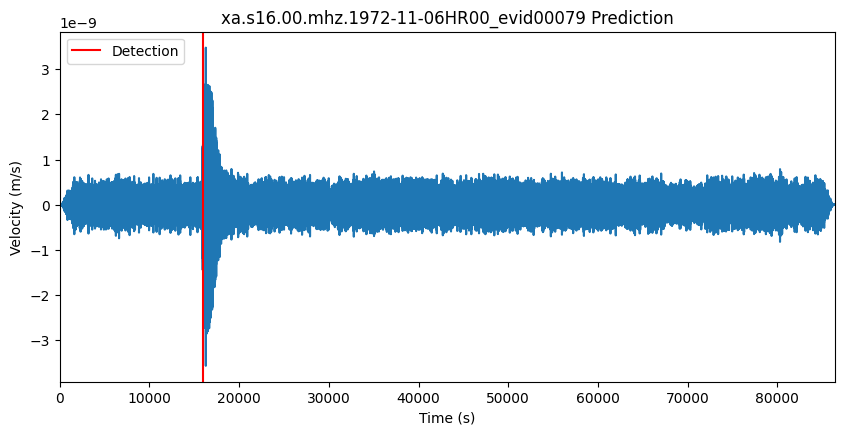

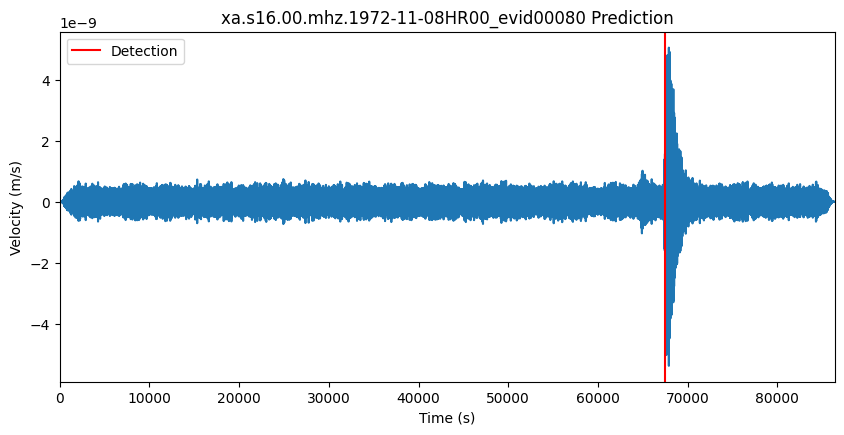

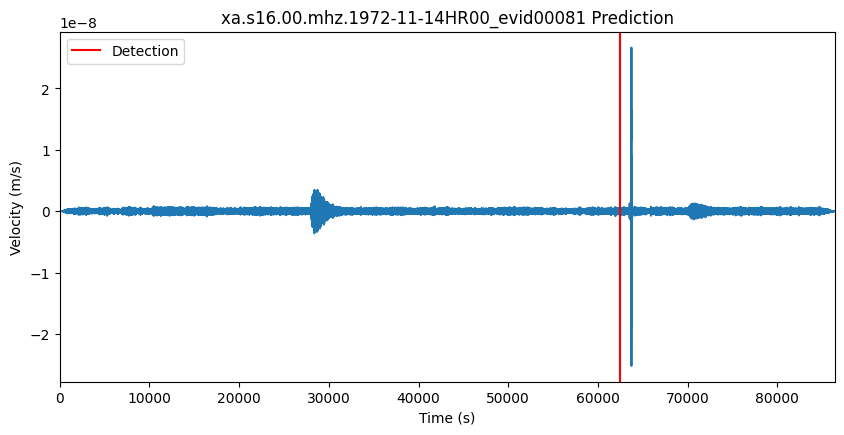

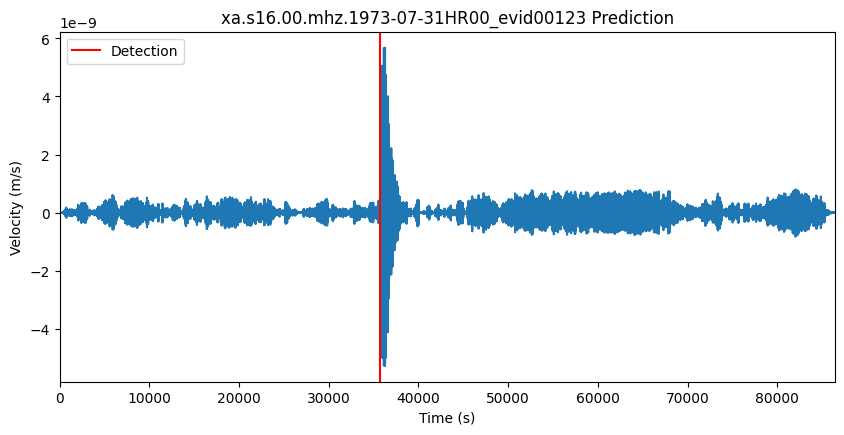

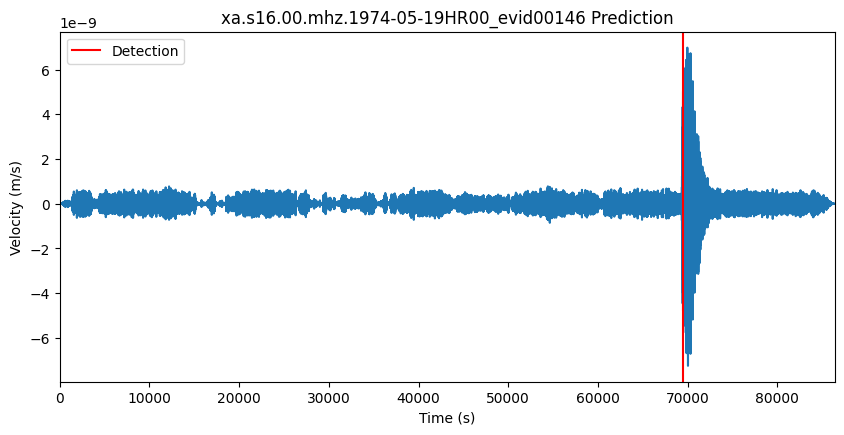

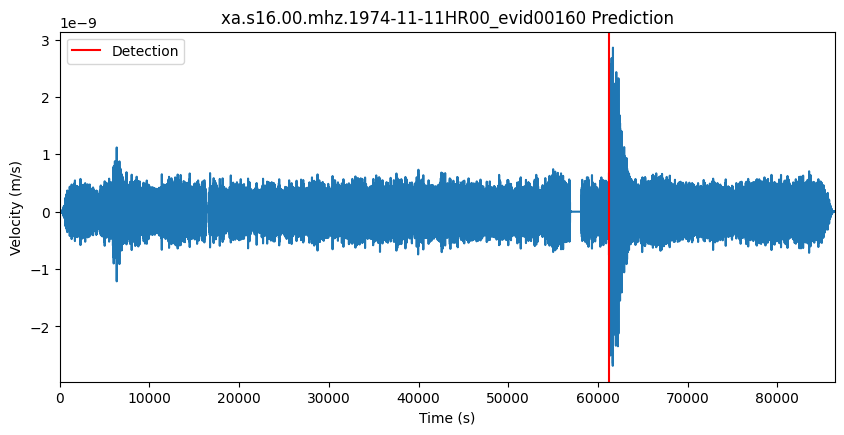

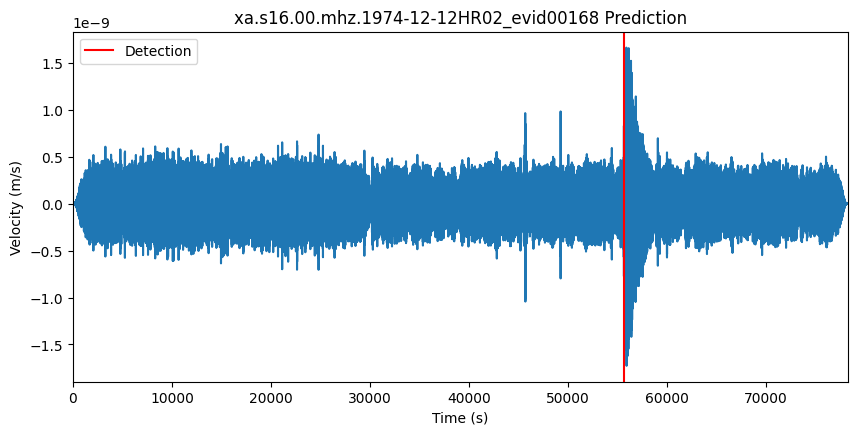

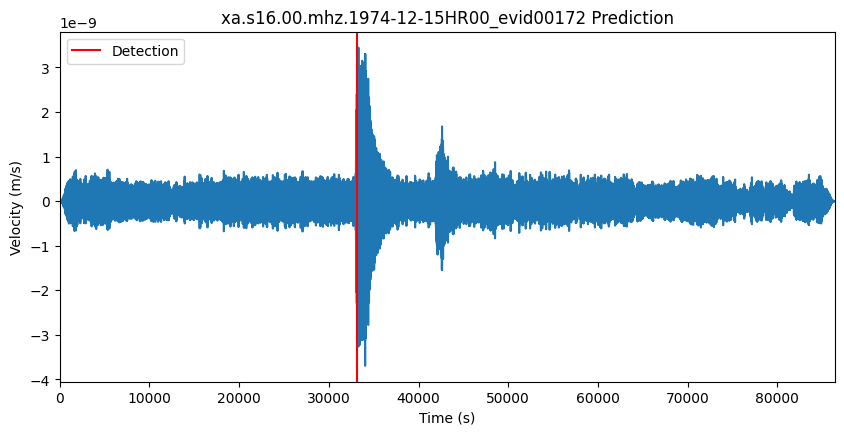

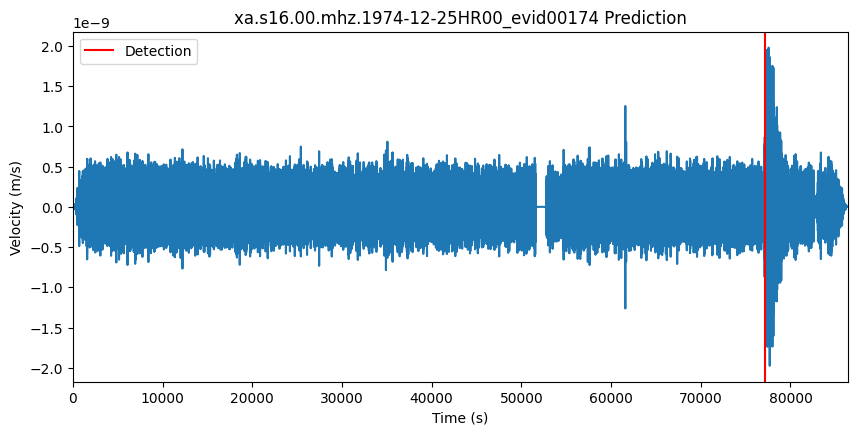

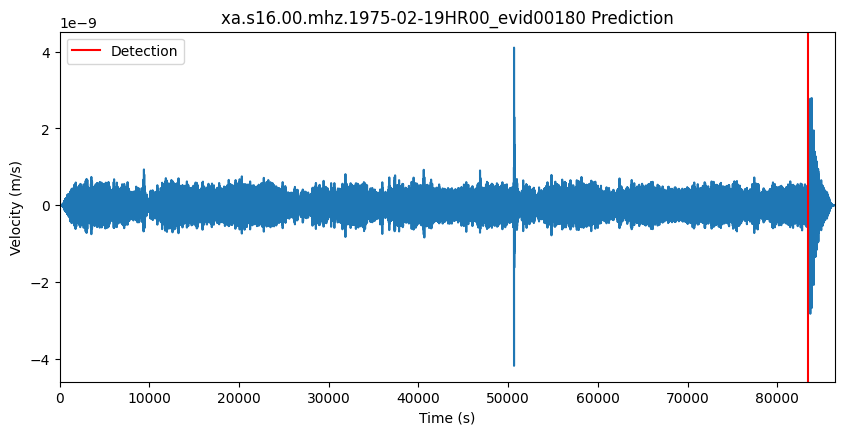

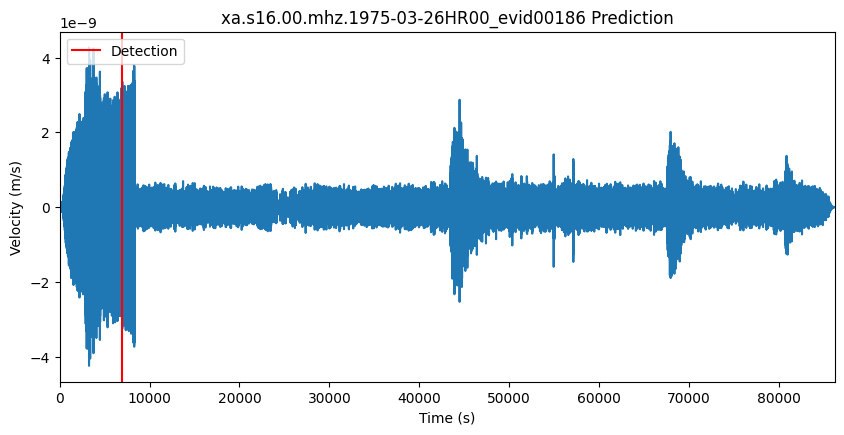

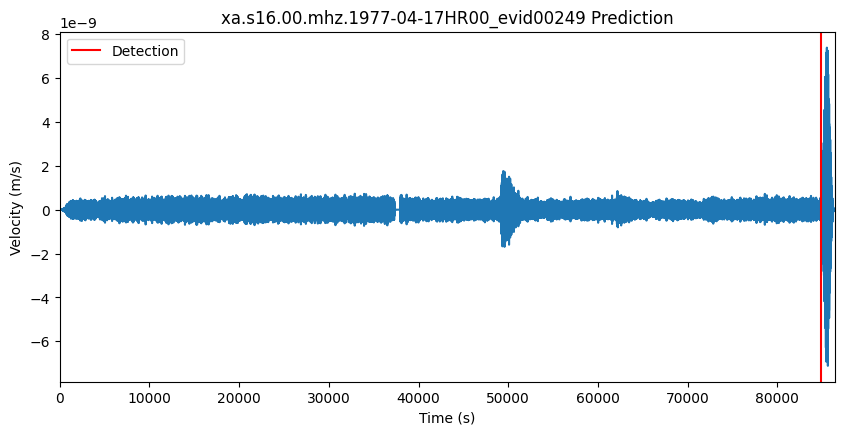

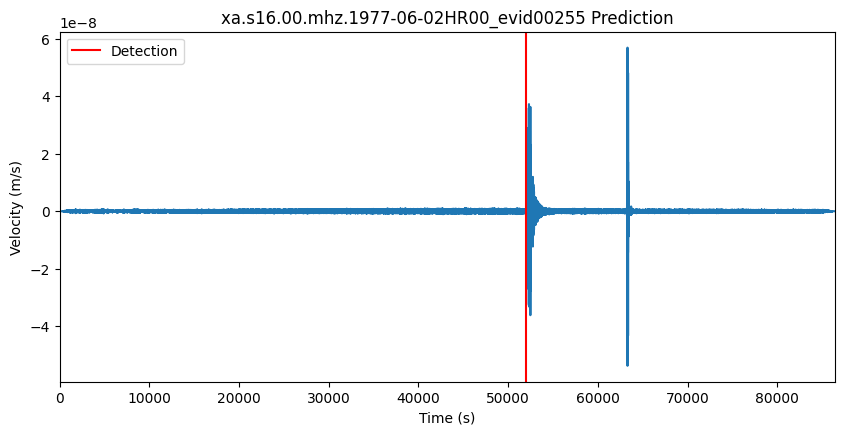

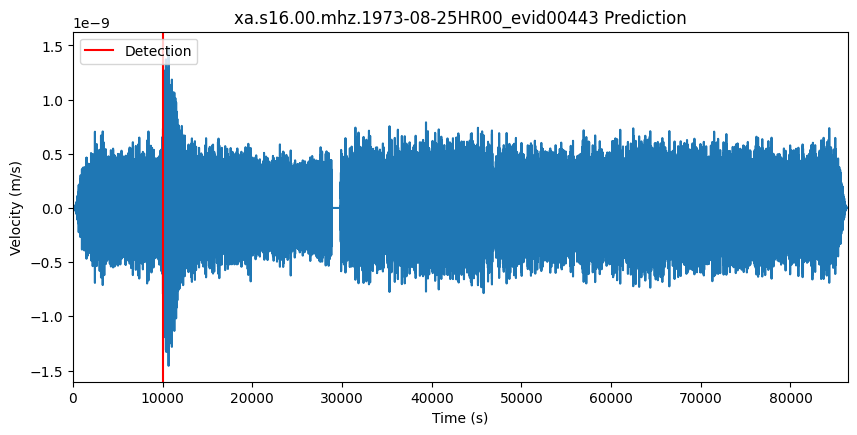

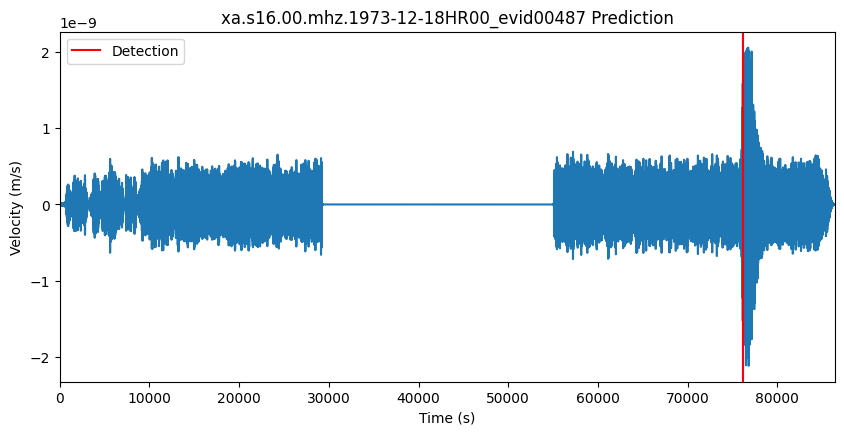

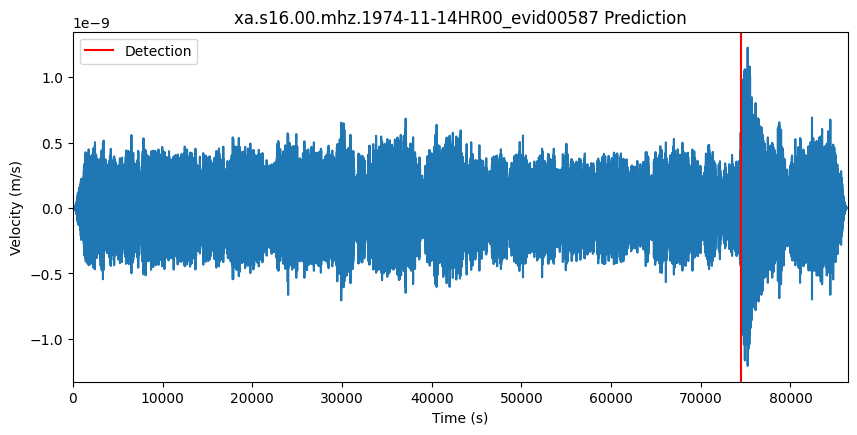

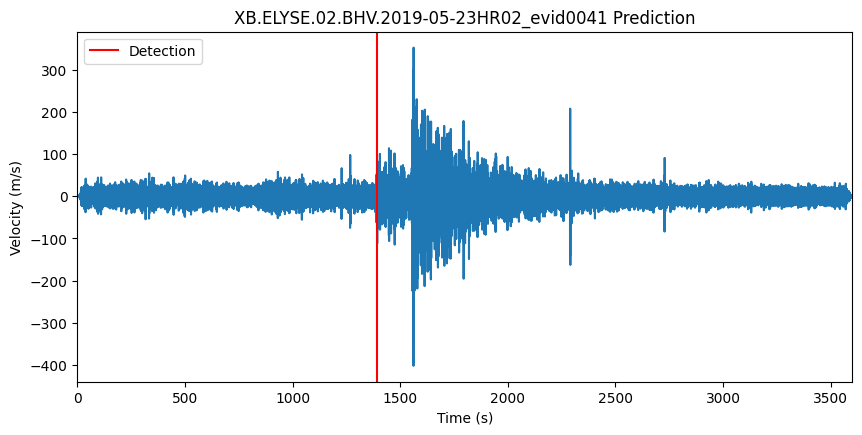

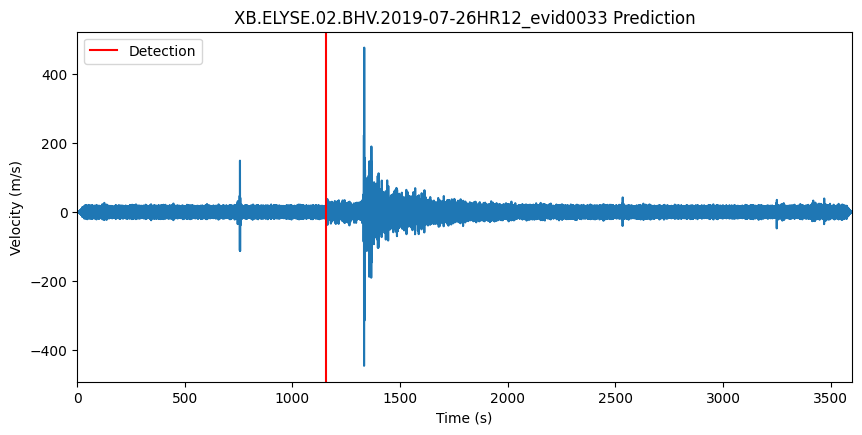

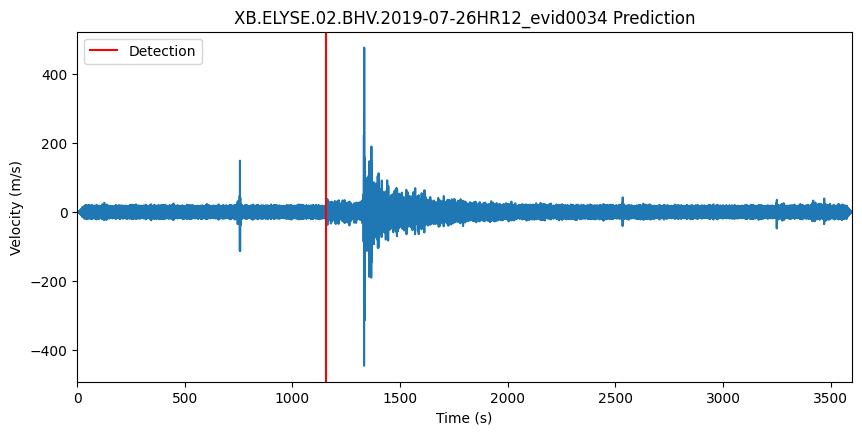

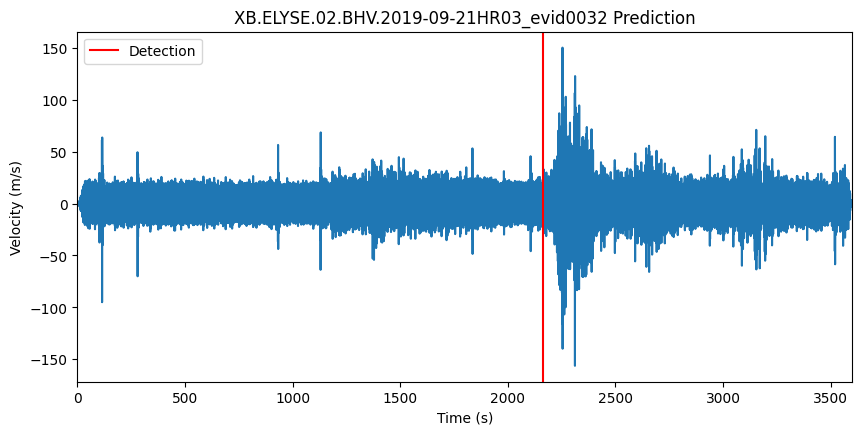

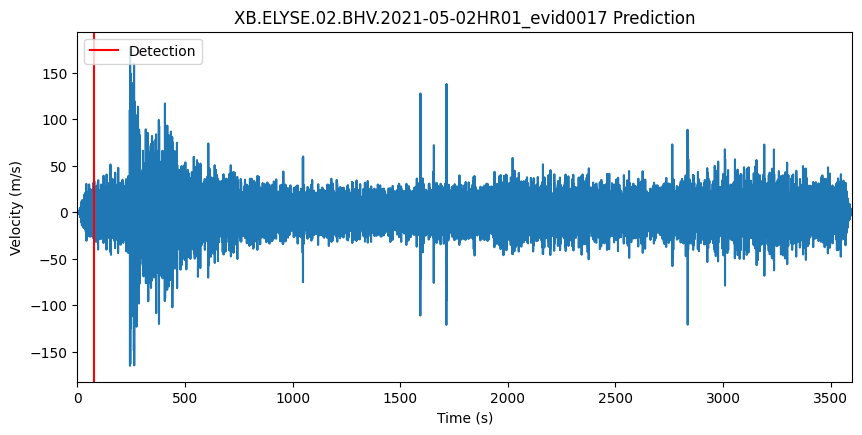

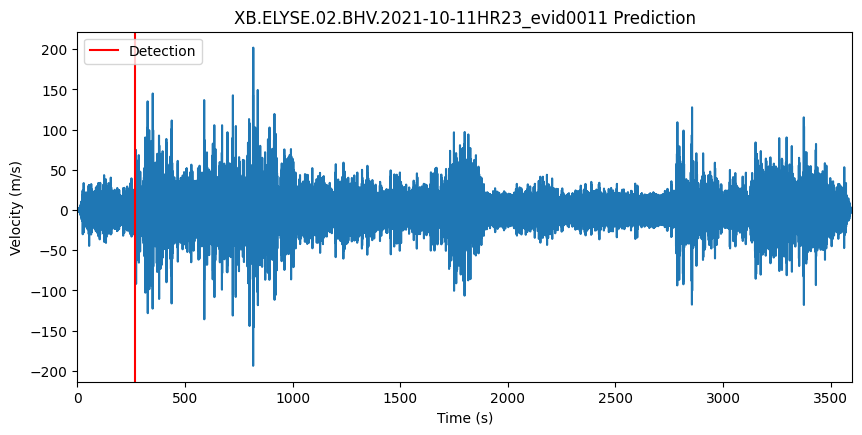

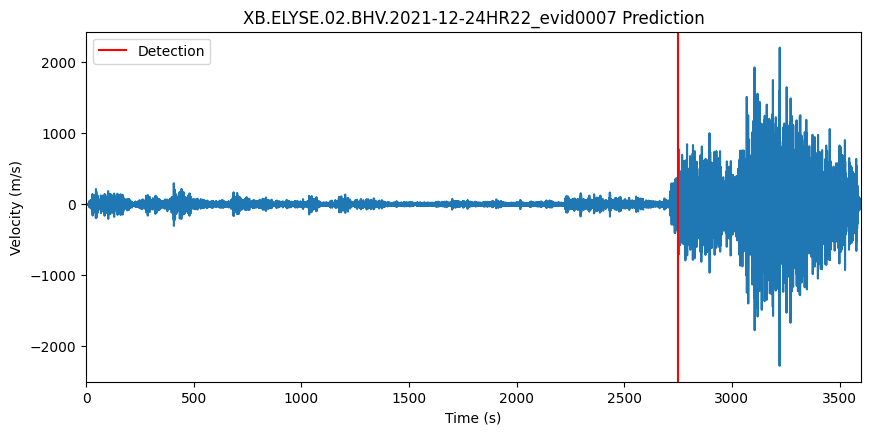

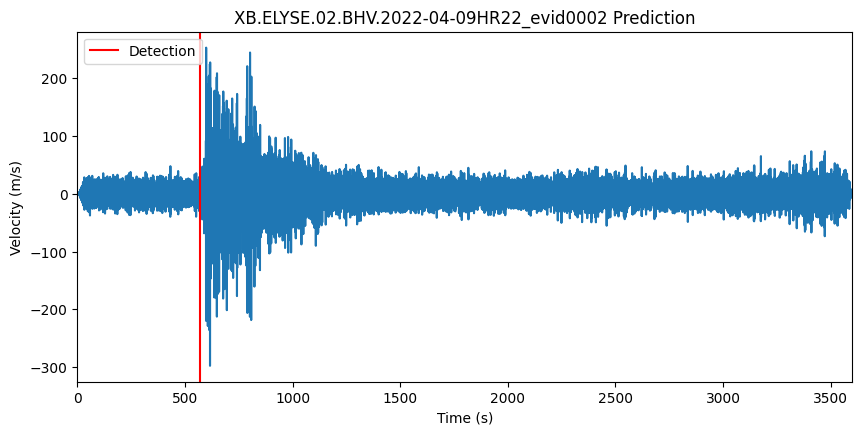

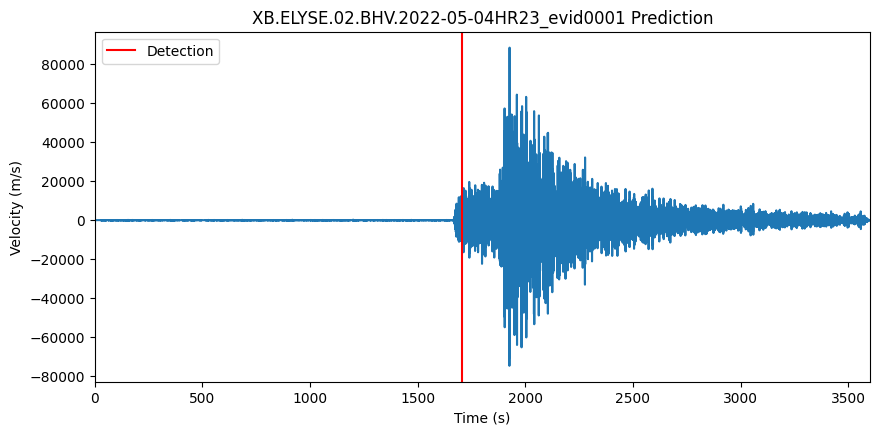

In [37]:
base_dir = "./data"
for planet in ["lunar", "mars"]:
    data_dir = f"{planet}/test/data"
    files = os.listdir(f"{base_dir}/{data_dir}")
    if planet == 'lunar':
        for catalog_dir in files:
            catalog_name = catalog_dir
            filenames = os.listdir(f"{base_dir}/{data_dir}/{catalog_dir}")
            filenames = [f.split(".csv")[0].split(".mseed")[0] for f in filenames]
            filenames = sorted(list(set(filenames)))
            create_catalog(base_dir, data_dir, filenames, catalog_name, 'lunar')
    else:
        catalog_name = "Mars_InSight_test_catalog_final"
        filenames = [f.split(".csv")[0].split(".mseed")[0] for f in files]
        filenames = sorted(list(set(filenames)))
        # print(filenames)
        create_catalog(base_dir, data_dir, filenames, catalog_name, 'mars')